# Tennessee Eastman Process - Comprehensive Exploratory Data Analysis

This notebook performs comprehensive exploratory data analysis on the Tennessee Eastman Process dataset with advanced statistical methods.

**Dataset Information:**
- TEP variables (columns 4-55) sampled every 3 minutes
- Training: 25 hours fault-free, 48 hours faulty data
- Faults introduced 1 hour into training datasets
- Completely standalone - loads raw data directly

## Analysis Sections
1. **Data Loading & Overview** - Load and inspect dataset
2. **Statistical Analysis** - Calculate comprehensive statistics
3. **Distribution Analysis** - Compare fault vs normal distributions
4. **Advanced Visualizations** - Time series, correlations, dimensionality reduction
   - **Time Series Analysis** - Pattern analysis around fault injection
   - **Outlier Detection** - IQR and Z-score based anomaly detection
   - **Feature Importance** - Statistical ranking and selection
   - **Distribution Analysis** - Normality testing and comparisons
   - **Multivariate Analysis** - PCA, clustering, dimensionality reduction
5. **Summary & Export** - Generate final summary and export results

## Key Advanced Methods Included:
- 📊 **Statistical Distribution Testing** (Shapiro-Wilk, Anderson-Darling)
- 🎯 **Feature Importance Ranking** (Variance, F-statistics, Mean differences)
- 🔍 **Outlier Detection** (IQR and Z-score methods)
- 📈 **Time Series Pattern Analysis** (Fault injection impact)
- 🔬 **Multivariate Analysis** (PCA, K-means clustering)
- 📉 **Correlation Analysis** (Pearson correlations and heatmaps)
- 🎨 **Advanced Visualizations** (t-SNE, Q-Q plots, loadings plots)

## 1. Data Loading & Overview

In [68]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadr
import os
import warnings
from scipy.stats import skew, kurtosis
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')
plt.style.use('default')

# Configuration
OUTPUT_PATH = "output"
VERSION = "1.00"
TARGET_VARIABLE_COLUMN_NAME = "faultNumber"
SIMULATION_RUN_COLUMN_NAME = "simulationRun"
FAULT_INJECTION_STARTING_POINT = 160

print("🔧 EDA Setup Complete")

🔧 EDA Setup Complete


In [69]:
# Utility functions
def save_plot(plot_name: str, suffix: str = ""):
    """Save current matplotlib figure."""
    base_dir = os.path.join(OUTPUT_PATH, "data", "EDA")
    os.makedirs(base_dir, exist_ok=True)
    filename = f"{plot_name}_{suffix}_v{VERSION}.png" if suffix else f"{plot_name}_v{VERSION}.png"
    filepath = os.path.join(base_dir, filename)
    plt.savefig(filepath, bbox_inches="tight", dpi=300)
    print(f"📊 Plot saved: {filepath}")

def save_dataframe(df: pd.DataFrame, name: str, suffix: str = ""):
    """Save DataFrame to CSV."""
    base_dir = os.path.join(OUTPUT_PATH, "data")
    os.makedirs(base_dir, exist_ok=True)
    filename = f"{name}_{suffix}_v{VERSION}.csv" if suffix else f"{name}_v{VERSION}.csv"
    filepath = os.path.join(base_dir, filename)
    df.to_csv(filepath, index=True)
    print(f"💾 Data saved: {filepath}")

def get_feature_columns(df: pd.DataFrame):
    """Get feature column names excluding metadata."""
    exclude_cols = [TARGET_VARIABLE_COLUMN_NAME, SIMULATION_RUN_COLUMN_NAME, "sample", "time"]
    return [col for col in df.columns if col not in exclude_cols]

print("⚙️ Utility functions loaded")

⚙️ Utility functions loaded


In [70]:
# Load Tennessee Eastman Process dataset
print("📥 Loading Tennessee Eastman Process dataset...")

# Load raw data files
fault_free_training_dict = pyreadr.read_r("data/TEP_FaultFree_Training.RData")
faulty_training_dict = pyreadr.read_r("data/TEP_Faulty_Training.RData")

# Extract DataFrames
DF_FF_TRAINING_RAW = fault_free_training_dict[list(fault_free_training_dict.keys())[0]]
DF_F_TRAINING_RAW = faulty_training_dict[list(faulty_training_dict.keys())[0]]

print("✅ Data loading complete!")
print(f"📋 Fault-free training data: {DF_FF_TRAINING_RAW.shape}")
print(f"📋 Faulty training data: {DF_F_TRAINING_RAW.shape}")
print(f"📋 Feature columns: {len(get_feature_columns(DF_F_TRAINING_RAW))}")
print(f"📋 Unique faults: {len(DF_F_TRAINING_RAW[TARGET_VARIABLE_COLUMN_NAME].unique())}")

📥 Loading Tennessee Eastman Process dataset...
✅ Data loading complete!
📋 Fault-free training data: (250000, 55)
📋 Faulty training data: (5000000, 55)
📋 Feature columns: 52
📋 Unique faults: 20


In [71]:
# Dataset Overview
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)

# Basic information
print(f"\n📊 Data Shapes:")
print(f"   Fault-free training: {DF_FF_TRAINING_RAW.shape}")
print(f"   Faulty training: {DF_F_TRAINING_RAW.shape}")

# Fault information
unique_faults = sorted(DF_F_TRAINING_RAW[TARGET_VARIABLE_COLUMN_NAME].unique())
unique_runs = sorted(DF_F_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME].unique())

print(f"\n🔍 Fault Information:")
print(f"   Unique fault numbers: {len(unique_faults)} faults ({min(unique_faults)}-{max(unique_faults)})")
print(f"   Simulation runs: {len(unique_runs)} runs ({min(unique_runs)}-{max(unique_runs)})")

# Sample data
print(f"\n📋 Sample Data:")
display(DF_F_TRAINING_RAW.head(3))
print(f"\n📋 Feature Columns: {get_feature_columns(DF_F_TRAINING_RAW)[:10]}... (showing first 10)")

DATASET OVERVIEW

📊 Data Shapes:
   Fault-free training: (250000, 55)
   Faulty training: (5000000, 55)

🔍 Fault Information:
   Unique fault numbers: 20 faults (1-20)
   Simulation runs: 500 runs (1.0-500.0)

📋 Sample Data:


,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,1,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,1,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,1,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530



📋 Feature Columns: ['xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 'xmeas_10']... (showing first 10)


## 2. Statistical Analysis

In [72]:
# Calculate comprehensive statistics per fault and simulation run
def calculate_comprehensive_statistics(df_faulty: pd.DataFrame, df_normal: pd.DataFrame):
    """Calculate comprehensive statistics for each fault run."""
    
    features = get_feature_columns(df_faulty)
    
    def compute_stats(df: pd.DataFrame):
        rows = []
        grouped = df.groupby([TARGET_VARIABLE_COLUMN_NAME, SIMULATION_RUN_COLUMN_NAME])
        
        for (fault, run), group in grouped:
            for feature in features:
                values = group[feature].dropna()
                if values.empty:
                    continue
                    
                rows.append({
                    TARGET_VARIABLE_COLUMN_NAME: fault,
                    SIMULATION_RUN_COLUMN_NAME: run,
                    "feature": feature,
                    "mean": values.mean(),
                    "std": values.std(),
                    "min": values.min(),
                    "max": values.max(),
                    "skewness": skew(values),
                    "kurtosis": kurtosis(values),
                    "autocorr_1": values.autocorr(lag=1) if len(values) > 1 else np.nan,
                })
        return pd.DataFrame(rows)
    
    # Use reduced dataset for faster computation (first 3 simulation runs)
    df_f_reduced = df_faulty[(df_faulty[SIMULATION_RUN_COLUMN_NAME] >= 1) & 
                             (df_faulty[SIMULATION_RUN_COLUMN_NAME] < 4)]
    df_ff_reduced = df_normal[(df_normal[SIMULATION_RUN_COLUMN_NAME] >= 1) & 
                              (df_normal[SIMULATION_RUN_COLUMN_NAME] < 4)]
    
    df_combined = pd.concat([df_ff_reduced, df_f_reduced], ignore_index=True)
    result_df = compute_stats(df_combined)
    
    save_dataframe(result_df, "comprehensive_statistics", "EDA")
    return result_df

print("📊 Calculating comprehensive statistics...")
stats_df = calculate_comprehensive_statistics(DF_F_TRAINING_RAW, DF_FF_TRAINING_RAW)

print(f"✅ Statistics calculated for {len(stats_df)} feature-fault-run combinations")
print(f"\n📈 Sample statistics:")
display(stats_df.head(10))

# Show statistics for specific fault
print(f"\n🔍 Example: Statistics for Fault 3, Run 1:")
fault_3_stats = stats_df.query("faultNumber == 3 and simulationRun == 1")
display(fault_3_stats.head())

📊 Calculating comprehensive statistics...
💾 Data saved: output/data/comprehensive_statistics_EDA_v1.00.csv
✅ Statistics calculated for 3276 feature-fault-run combinations

📈 Sample statistics:
💾 Data saved: output/data/comprehensive_statistics_EDA_v1.00.csv
✅ Statistics calculated for 3276 feature-fault-run combinations

📈 Sample statistics:


,faultNumber,simulationRun,feature,mean,std,min,max,skewness,kurtosis,autocorr_1
0,0.0,1.0,xmeas_1,0.250589,0.028053,0.16335,0.33642,0.092199,0.054638,0.603644
1,0.0,1.0,xmeas_2,3662.773200,32.682159,3564.60000,3775.00000,0.097979,0.332577,0.364918
2,0.0,1.0,xmeas_3,4509.577200,38.719848,4400.50000,4613.40000,0.064323,-0.009796,0.432310
3,0.0,1.0,xmeas_4,9.344804,0.078888,9.12660,9.57570,0.129982,-0.181824,0.263978
4,0.0,1.0,xmeas_5,26.907058,0.214969,26.20100,27.50100,-0.125848,0.086170,-0.012240
5,0.0,1.0,xmeas_6,42.340676,0.220381,41.79600,43.04000,0.234513,-0.097109,-0.003553
6,0.0,1.0,xmeas_7,2704.357000,5.970479,2692.30000,2717.70000,0.223098,-0.828060,0.944140
7,0.0,1.0,xmeas_8,75.017246,0.527373,73.67700,76.53800,0.019236,0.047426,0.201402
8,0.0,1.0,xmeas_9,120.400040,0.019513,120.32000,120.47000,-0.112534,0.395387,-0.171673
9,0.0,1.0,xmeas_10,0.337032,0.011672,0.30296,0.37536,-0.026209,0.504947,0.537800



🔍 Example: Statistics for Fault 3, Run 1:


,faultNumber,simulationRun,feature,mean,std,min,max,skewness,kurtosis,autocorr_1
468,3.0,1.0,xmeas_1,0.250590,0.028047,0.1633,0.33602,0.087095,0.045981,0.603482
469,3.0,1.0,xmeas_2,3662.771000,32.686947,3564.6000,3775.10000,0.098014,0.332652,0.365085
470,3.0,1.0,xmeas_3,4509.553200,38.705415,4399.9000,4613.50000,0.061717,-0.003970,0.431878
471,3.0,1.0,xmeas_4,9.344781,0.078973,9.1266,9.57600,0.129034,-0.182764,0.265598
472,3.0,1.0,xmeas_5,26.907070,0.214965,26.2010,27.50100,-0.125808,0.085780,-0.012288


## 3. Distribution Analysis

📊 Creating distribution comparisons...
📊 Plot saved: output/data/EDA/boxplot_comparison_fault_3_run_1_v1.00.png
📊 Plot saved: output/data/EDA/boxplot_comparison_fault_3_run_1_v1.00.png


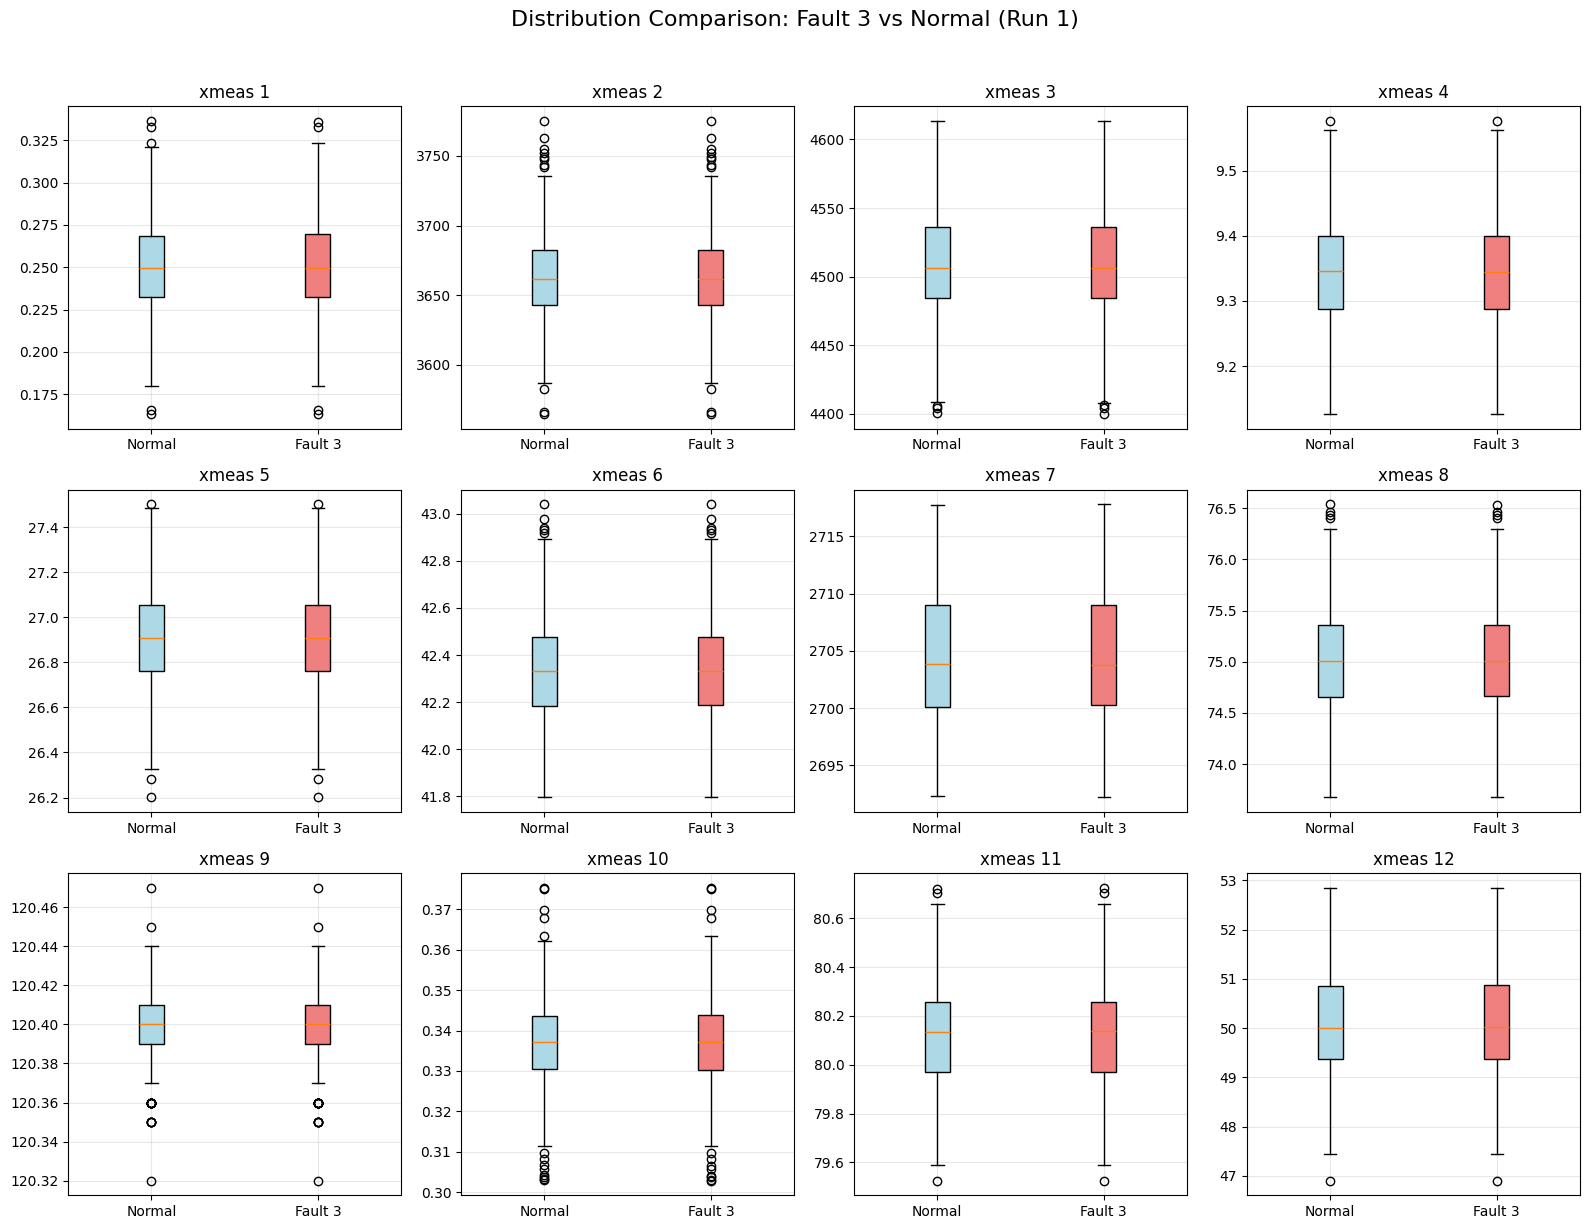

In [73]:
# Distribution comparison functions
def create_boxplot_comparison(df_fault, df_normal, fault_number=3, simulation_run=1, max_features=12):
    """Create boxplots comparing fault vs normal data."""
    
    # Filter data
    df_fault_filtered = df_fault[
        (df_fault[TARGET_VARIABLE_COLUMN_NAME] == fault_number) &
        (df_fault[SIMULATION_RUN_COLUMN_NAME] == simulation_run)
    ]
    df_normal_filtered = df_normal[
        (df_normal[TARGET_VARIABLE_COLUMN_NAME] == 0) &
        (df_normal[SIMULATION_RUN_COLUMN_NAME] == simulation_run)
    ]
    
    if df_fault_filtered.empty or df_normal_filtered.empty:
        print(f"❌ No data found for fault {fault_number}, run {simulation_run}")
        return
    
    # Select features
    feature_columns = get_feature_columns(df_fault)[:max_features]
    
    # Create subplots
    num_cols = 4
    num_rows = int(np.ceil(len(feature_columns) / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4 * num_rows))
    fig.suptitle(f"Distribution Comparison: Fault {fault_number} vs Normal (Run {simulation_run})", 
                fontsize=16, y=1.02)
    
    # Flatten axes for easier indexing
    axes_flat = axes.flatten() if num_rows > 1 else [axes] if num_cols == 1 else axes
    
    for i, feature in enumerate(feature_columns):
        ax = axes_flat[i]
        
        # Prepare data for boxplot
        data_to_plot = [
            df_normal_filtered[feature].dropna(),
            df_fault_filtered[feature].dropna()
        ]
        labels = ['Normal', f'Fault {fault_number}']
        
        bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
        bp['boxes'][0].set_facecolor('lightblue')
        bp['boxes'][1].set_facecolor('lightcoral')
        
        ax.set_title(feature.replace('_', ' '))
        ax.grid(True, alpha=0.3)
    
    # Remove empty subplots
    for i in range(len(feature_columns), len(axes_flat)):
        fig.delaxes(axes_flat[i])
    
    plt.tight_layout()
    save_plot("boxplot_comparison", f"fault_{fault_number}_run_{simulation_run}")
    plt.show()

# Generate distribution visualizations
print("📊 Creating distribution comparisons...")
create_boxplot_comparison(DF_F_TRAINING_RAW, DF_FF_TRAINING_RAW, fault_number=3, simulation_run=1)

🔍 Analyzing fault distribution...
📊 Plot saved: output/data/EDA/fault_class_distribution_v1.00.png
📊 Plot saved: output/data/EDA/fault_class_distribution_v1.00.png


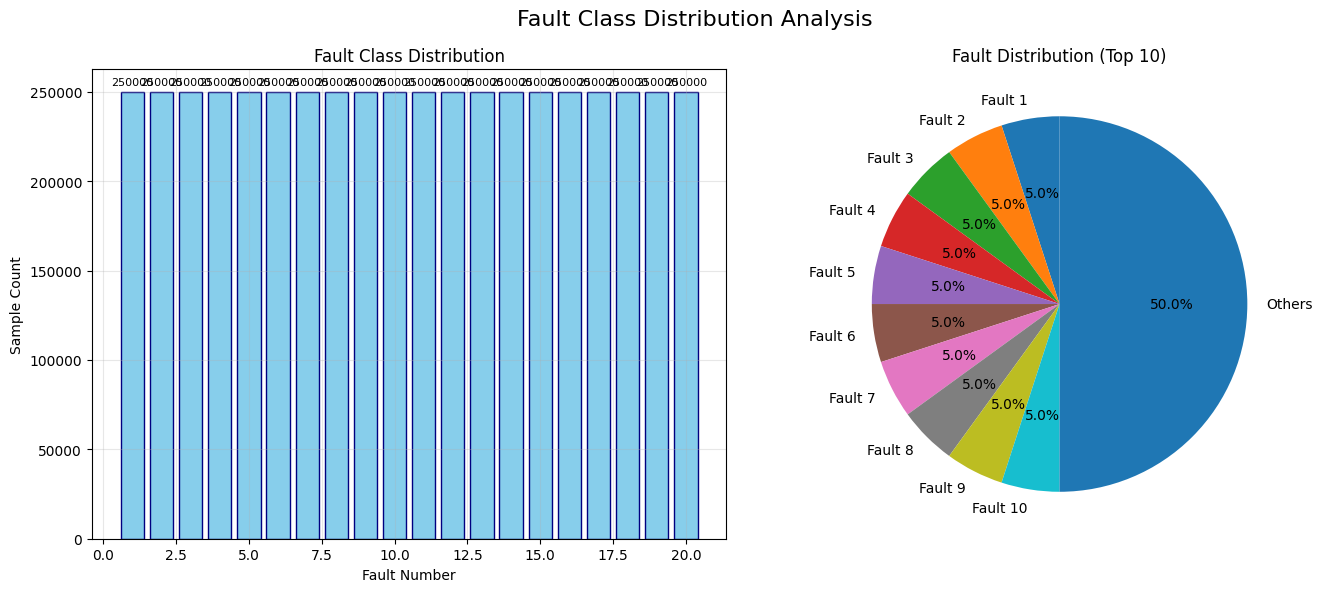

💾 Data saved: output/data/fault_distribution_EDA_v1.00.csv
📊 Fault Distribution Summary:
   Total faults: 20
   Total samples: 5,000,000
   Most common fault: 1 (250,000 samples)


In [74]:
# Fault distribution analysis
def analyze_fault_distribution():
    """Analyze the distribution of fault classes."""
    
    fault_counts = DF_F_TRAINING_RAW[TARGET_VARIABLE_COLUMN_NAME].value_counts().sort_index()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle("Fault Class Distribution Analysis", fontsize=16)
    
    # Bar plot
    ax1.bar(fault_counts.index, fault_counts.values, color='skyblue', edgecolor='navy')
    ax1.set_xlabel('Fault Number')
    ax1.set_ylabel('Sample Count')
    ax1.set_title('Fault Class Distribution')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for fault, count in fault_counts.items():
        ax1.text(fault, count + max(fault_counts.values)*0.01, str(count), 
                ha='center', va='bottom', fontsize=8)
    
    # Pie chart (top 10 faults)
    top_10_faults = fault_counts.head(10)
    others_count = fault_counts.iloc[10:].sum() if len(fault_counts) > 10 else 0
    
    if others_count > 0:
        pie_data = list(top_10_faults.values) + [others_count]
        pie_labels = [f'Fault {i}' for i in top_10_faults.index] + ['Others']
    else:
        pie_data = top_10_faults.values
        pie_labels = [f'Fault {i}' for i in top_10_faults.index]
    
    ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Fault Distribution (Top 10)')
    
    plt.tight_layout()
    save_plot("fault_class_distribution")
    plt.show()
    
    # Save distribution data
    fault_dist_df = pd.DataFrame({
        'Fault_Number': fault_counts.index,
        'Sample_Count': fault_counts.values,
        'Percentage': (fault_counts.values / fault_counts.sum() * 100).round(2)
    })
    save_dataframe(fault_dist_df, "fault_distribution", "EDA")
    
    print(f"📊 Fault Distribution Summary:")
    print(f"   Total faults: {len(fault_counts)}")
    print(f"   Total samples: {fault_counts.sum():,}")
    print(f"   Most common fault: {fault_counts.index[0]} ({fault_counts.iloc[0]:,} samples)")
    
    return fault_dist_df

print("🔍 Analyzing fault distribution...")
fault_distribution = analyze_fault_distribution()

## 4. Advanced Visualizations

🔍 Performing correlation analysis...
📊 Plot saved: output/data/EDA/correlation_analysis_v1.00.png
📊 Plot saved: output/data/EDA/correlation_analysis_v1.00.png


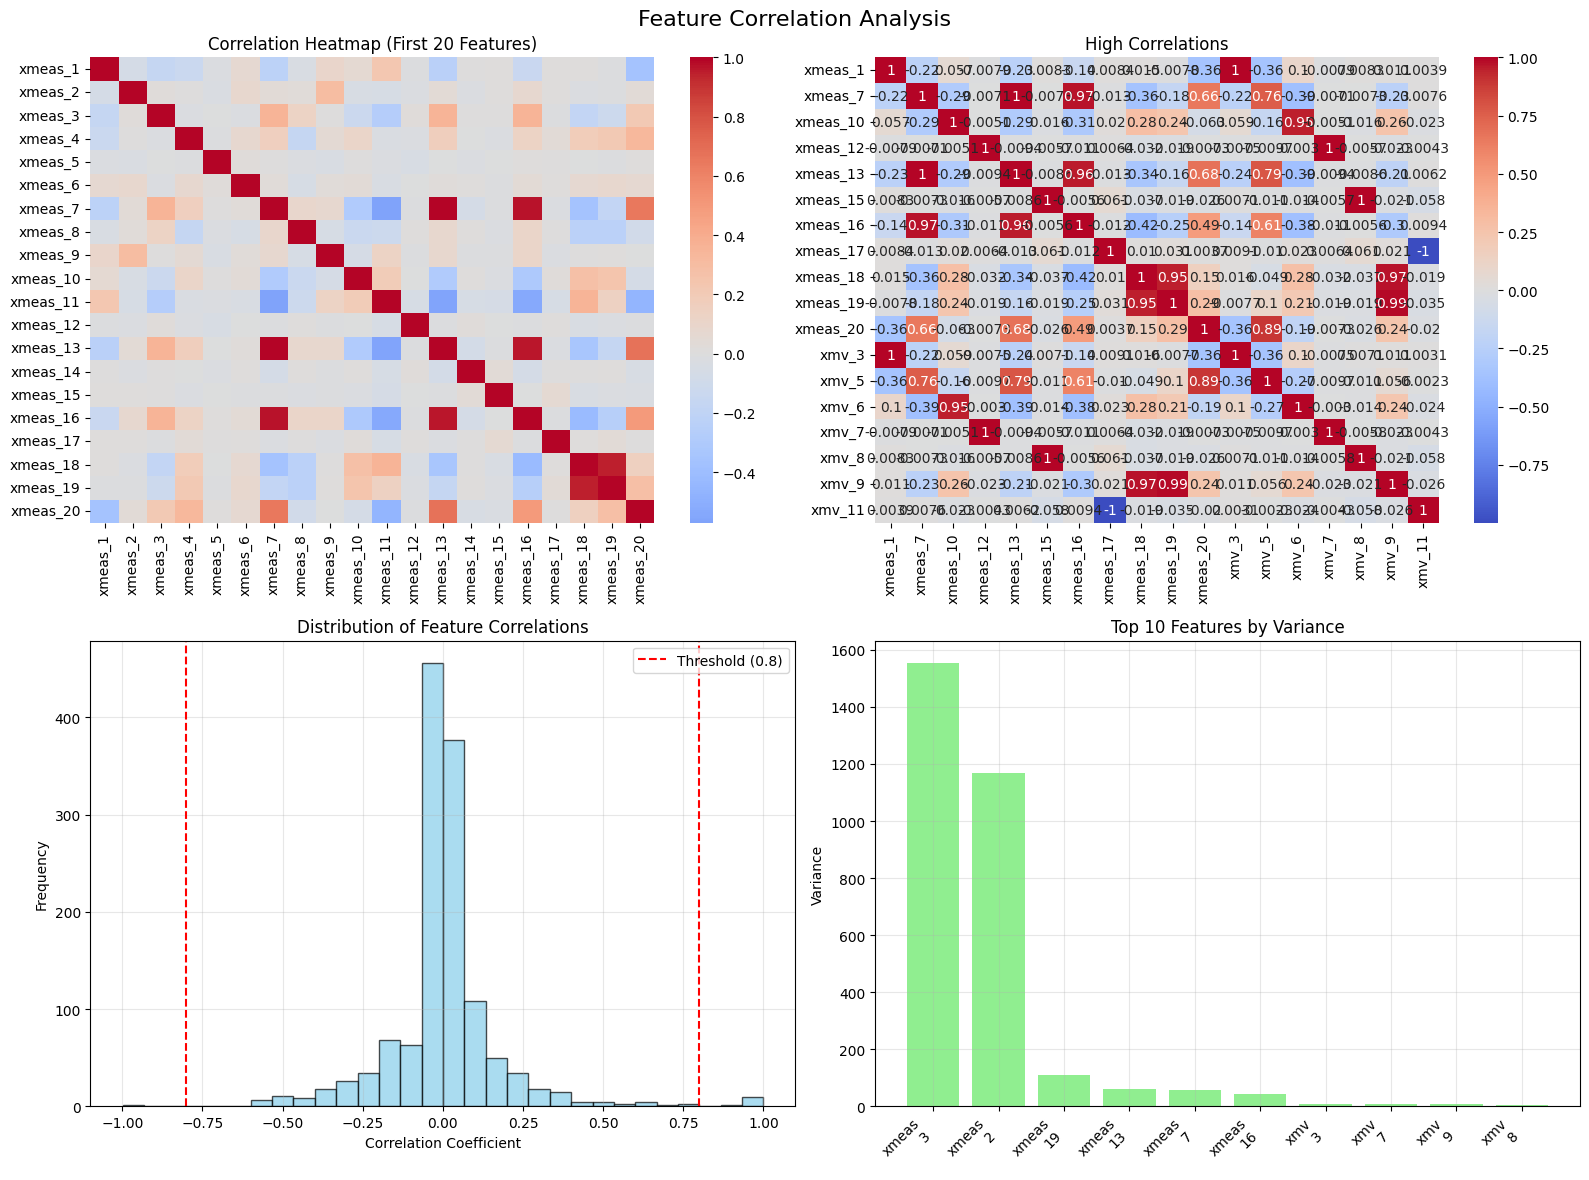

In [75]:
# Correlation analysis
def plot_correlation_analysis(df, sample_size=5000):
    """Analyze and visualize feature correlations."""
    
    # Sample data for faster computation
    df_sample = df.sample(n=min(sample_size, len(df)), random_state=42)
    feature_cols = get_feature_columns(df_sample)
    
    # Calculate correlation matrix
    corr_matrix = df_sample[feature_cols].corr()
    
    # Create visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle("Feature Correlation Analysis", fontsize=16)
    
    # 1. Correlation heatmap (first 20 features)
    selected_features = feature_cols[:20]
    corr_subset = corr_matrix.loc[selected_features, selected_features]
    sns.heatmap(corr_subset, annot=False, cmap='coolwarm', center=0, ax=ax1)
    ax1.set_title("Correlation Heatmap (First 20 Features)")
    
    # 2. High correlations
    corr_abs = corr_matrix.abs()
    np.fill_diagonal(corr_abs.values, 0)
    high_corr_mask = corr_abs > 0.8
    
    if high_corr_mask.any().any():
        high_corr_features = corr_abs.columns[high_corr_mask.any()]
        if len(high_corr_features) > 1:
            high_corr_matrix = corr_matrix.loc[high_corr_features, high_corr_features]
            sns.heatmap(high_corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax2)
            ax2.set_title("High Correlations (|r| > 0.8)")
        else:
            ax2.text(0.5, 0.5, "No high correlations\nfound (|r| > 0.8)", 
                    ha='center', va='center', transform=ax2.transAxes)
    else:
        ax2.text(0.5, 0.5, "No high correlations\nfound (|r| > 0.8)", 
                ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title("High Correlations")
    
    # 3. Correlation distribution
    corr_values = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
    ax3.hist(corr_values, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax3.axvline(0.8, color='red', linestyle='--', label='Threshold (0.8)')
    ax3.axvline(-0.8, color='red', linestyle='--')
    ax3.set_xlabel('Correlation Coefficient')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Feature Correlations')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Feature variance
    feature_variances = df_sample[feature_cols].var().sort_values(ascending=False)
    top_10_var = feature_variances.head(10)
    ax4.bar(range(len(top_10_var)), top_10_var.values, color='lightgreen')
    ax4.set_xticks(range(len(top_10_var)))
    ax4.set_xticklabels([name.replace('_', '\n') for name in top_10_var.index], 
                       rotation=45, ha='right')
    ax4.set_ylabel('Variance')
    ax4.set_title('Top 10 Features by Variance')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_plot("correlation_analysis")
    plt.show()

print("🔍 Performing correlation analysis...")
plot_correlation_analysis(DF_FF_TRAINING_RAW)

🎯 Creating t-SNE visualization...
🔍 Applying t-SNE to 60 samples with 52 features...
🔍 Applying t-SNE to 60 samples with 52 features...
📊 Plot saved: output/data/EDA/tsne_visualization_samples_60_v1.00.png
📊 Plot saved: output/data/EDA/tsne_visualization_samples_60_v1.00.png


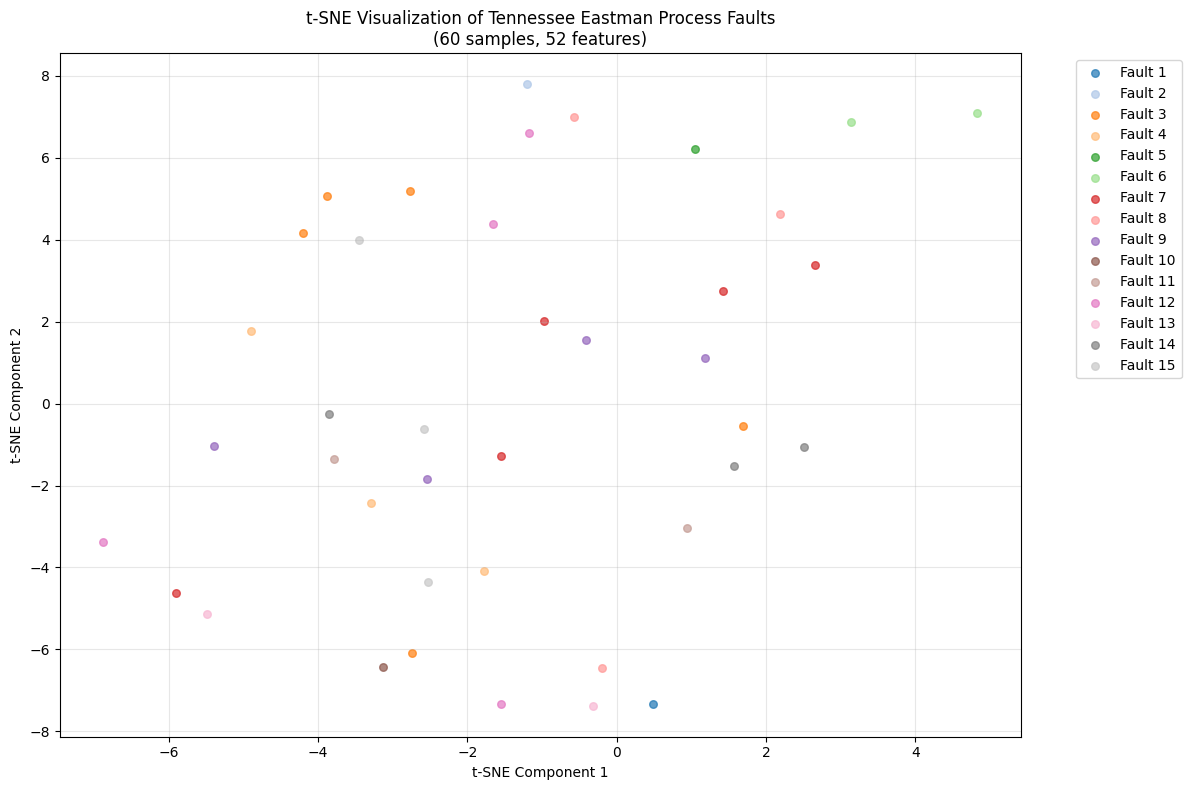

In [76]:
# t-SNE visualization for dimensionality reduction
def create_tsne_visualization(df_fault, sample_size=2000, step=50):
    """Create t-SNE visualization of fault clusters."""
    
    # Sample data for faster computation
    df_sample = df_fault.sample(n=min(sample_size, len(df_fault)), random_state=42)
    df_tsne = df_sample.iloc[::step].reset_index(drop=True)
    
    if len(df_tsne) < 50:
        print("❌ Insufficient data for t-SNE visualization")
        return
    
    feature_cols = get_feature_columns(df_tsne)
    X = df_tsne[feature_cols].values
    y = df_tsne[TARGET_VARIABLE_COLUMN_NAME].values
    
    print(f"🔍 Applying t-SNE to {len(df_tsne)} samples with {len(feature_cols)} features...")
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, learning_rate='auto', init='random', 
                random_state=42, perplexity=min(30, len(df_tsne)//4))
    X_embedded = tsne.fit_transform(X)
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    
    # Create scatter plot with different colors for each fault
    unique_faults = sorted(np.unique(y))
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_faults)))
    
    for i, fault in enumerate(unique_faults[:15]):  # Limit to first 15 faults for clarity
        mask = y == fault
        plt.scatter(X_embedded[mask, 0], X_embedded[mask, 1], 
                   c=[colors[i]], label=f'Fault {fault}', alpha=0.7, s=30)
    
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title(f't-SNE Visualization of Tennessee Eastman Process Faults\n'
             f'({len(df_tsne)} samples, {len(feature_cols)} features)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_plot("tsne_visualization", f"samples_{len(df_tsne)}")
    plt.show()

print("🎯 Creating t-SNE visualization...")
create_tsne_visualization(DF_F_TRAINING_RAW, sample_size=3000)

🕐 Creating time series analysis...
📊 Plot saved: output/data/EDA/time_series_analysis_fault_3_run_1_v1.00.png
📊 Plot saved: output/data/EDA/time_series_analysis_fault_3_run_1_v1.00.png


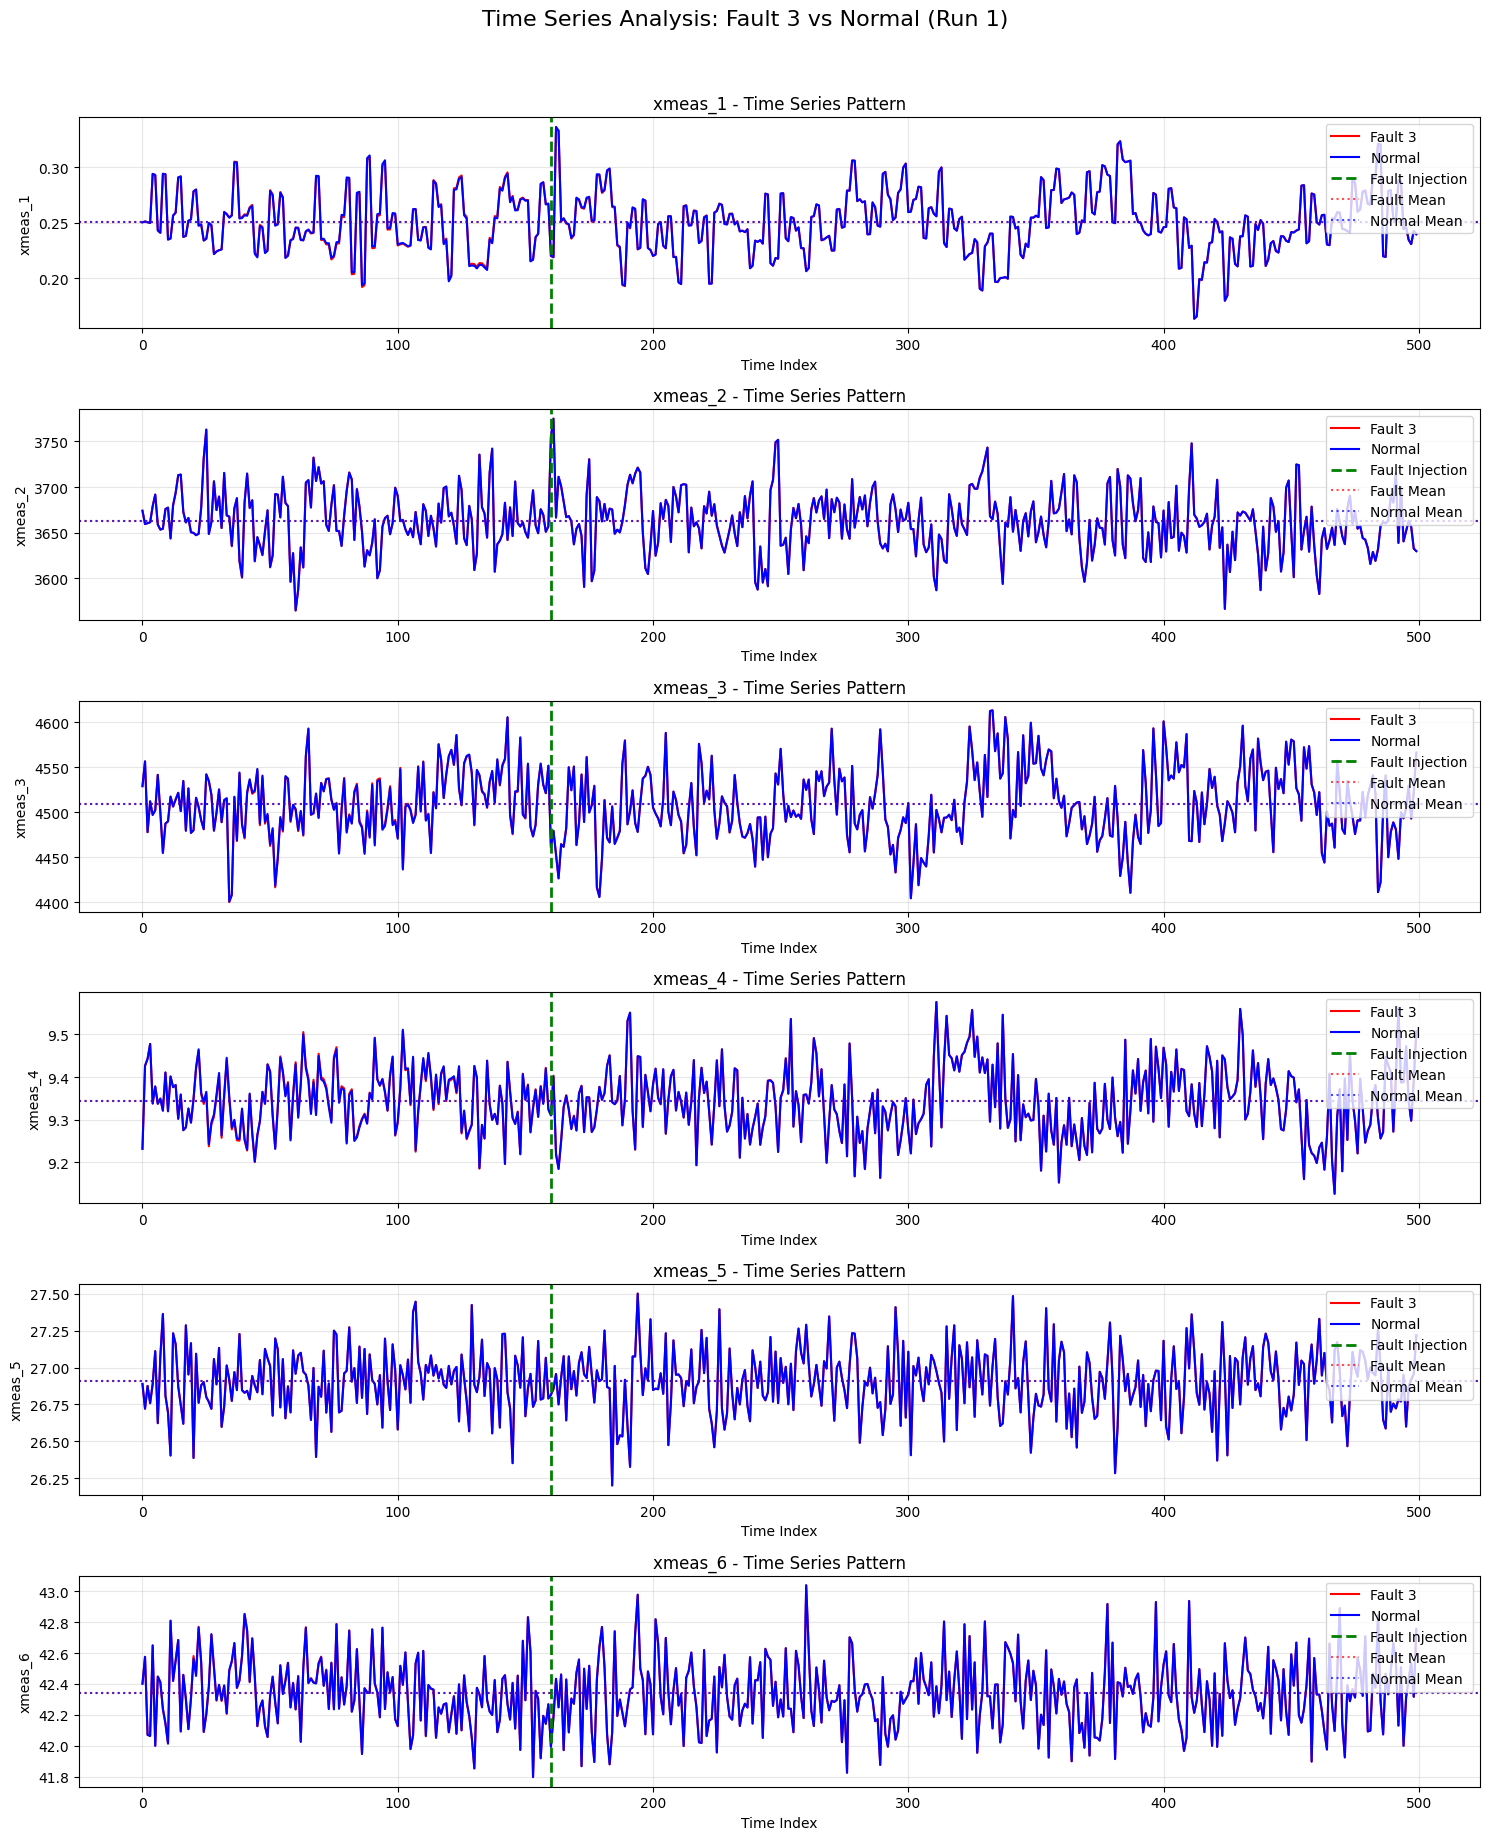

In [77]:
# Time Series Analysis
def analyze_time_series_patterns(df_fault, df_normal, fault_number=3, simulation_run=1, num_features=6):
    """Analyze time series patterns around fault injection."""
    
    # Filter data for specific fault and simulation run
    df_fault_filtered = df_fault[
        (df_fault[TARGET_VARIABLE_COLUMN_NAME] == fault_number) &
        (df_fault[SIMULATION_RUN_COLUMN_NAME] == simulation_run)
    ].reset_index(drop=True)
    
    df_normal_filtered = df_normal[
        (df_normal[TARGET_VARIABLE_COLUMN_NAME] == 0) &
        (df_normal[SIMULATION_RUN_COLUMN_NAME] == simulation_run)
    ].reset_index(drop=True)
    
    if df_fault_filtered.empty or df_normal_filtered.empty:
        print(f"❌ No data found for fault {fault_number}, run {simulation_run}")
        return
    
    feature_cols = get_feature_columns(df_fault)[:num_features]
    
    fig, axes = plt.subplots(num_features, 1, figsize=(15, 3 * num_features))
    fig.suptitle(f'Time Series Analysis: Fault {fault_number} vs Normal (Run {simulation_run})', 
                fontsize=16, y=1.02)
    
    if num_features == 1:
        axes = [axes]
    
    for i, feature in enumerate(feature_cols):
        ax = axes[i]
        
        # Plot time series
        time_index = range(len(df_fault_filtered))
        ax.plot(time_index, df_fault_filtered[feature], 
               label=f'Fault {fault_number}', color='red', linewidth=1.5)
        ax.plot(time_index, df_normal_filtered[feature][:len(df_fault_filtered)], 
               label='Normal', color='blue', linewidth=1.5)
        
        # Mark fault injection point
        ax.axvline(FAULT_INJECTION_STARTING_POINT, color='green', 
                  linestyle='--', linewidth=2, label='Fault Injection')
        
        # Add statistical lines
        fault_mean = df_fault_filtered[feature].mean()
        normal_mean = df_normal_filtered[feature].mean()
        ax.axhline(fault_mean, color='red', linestyle=':', alpha=0.7, label='Fault Mean')
        ax.axhline(normal_mean, color='blue', linestyle=':', alpha=0.7, label='Normal Mean')
        
        ax.set_title(f'{feature} - Time Series Pattern')
        ax.set_xlabel('Time Index')
        ax.set_ylabel(feature)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right')
    
    plt.tight_layout()
    save_plot("time_series_analysis", f"fault_{fault_number}_run_{simulation_run}")
    plt.show()

print("🕐 Creating time series analysis...")
analyze_time_series_patterns(DF_F_TRAINING_RAW, DF_FF_TRAINING_RAW)

## 4.1. Advanced EDA Methods

This section includes advanced exploratory data analysis techniques:
- **Time Series Analysis**: Pattern analysis around fault injection points
- **Outlier Detection**: Identification of anomalous data points using IQR and Z-score methods
- **Feature Importance**: Statistical ranking of features using variance, mean differences, and F-statistics
- **Distribution Analysis**: Normality testing and statistical distribution comparison
- **Multivariate Analysis**: PCA, clustering, and dimensionality reduction techniques

🎯 Detecting outliers...
📊 Plot saved: output/data/EDA/outlier_detection_iqr_v1.00.png
📊 Plot saved: output/data/EDA/outlier_detection_iqr_v1.00.png


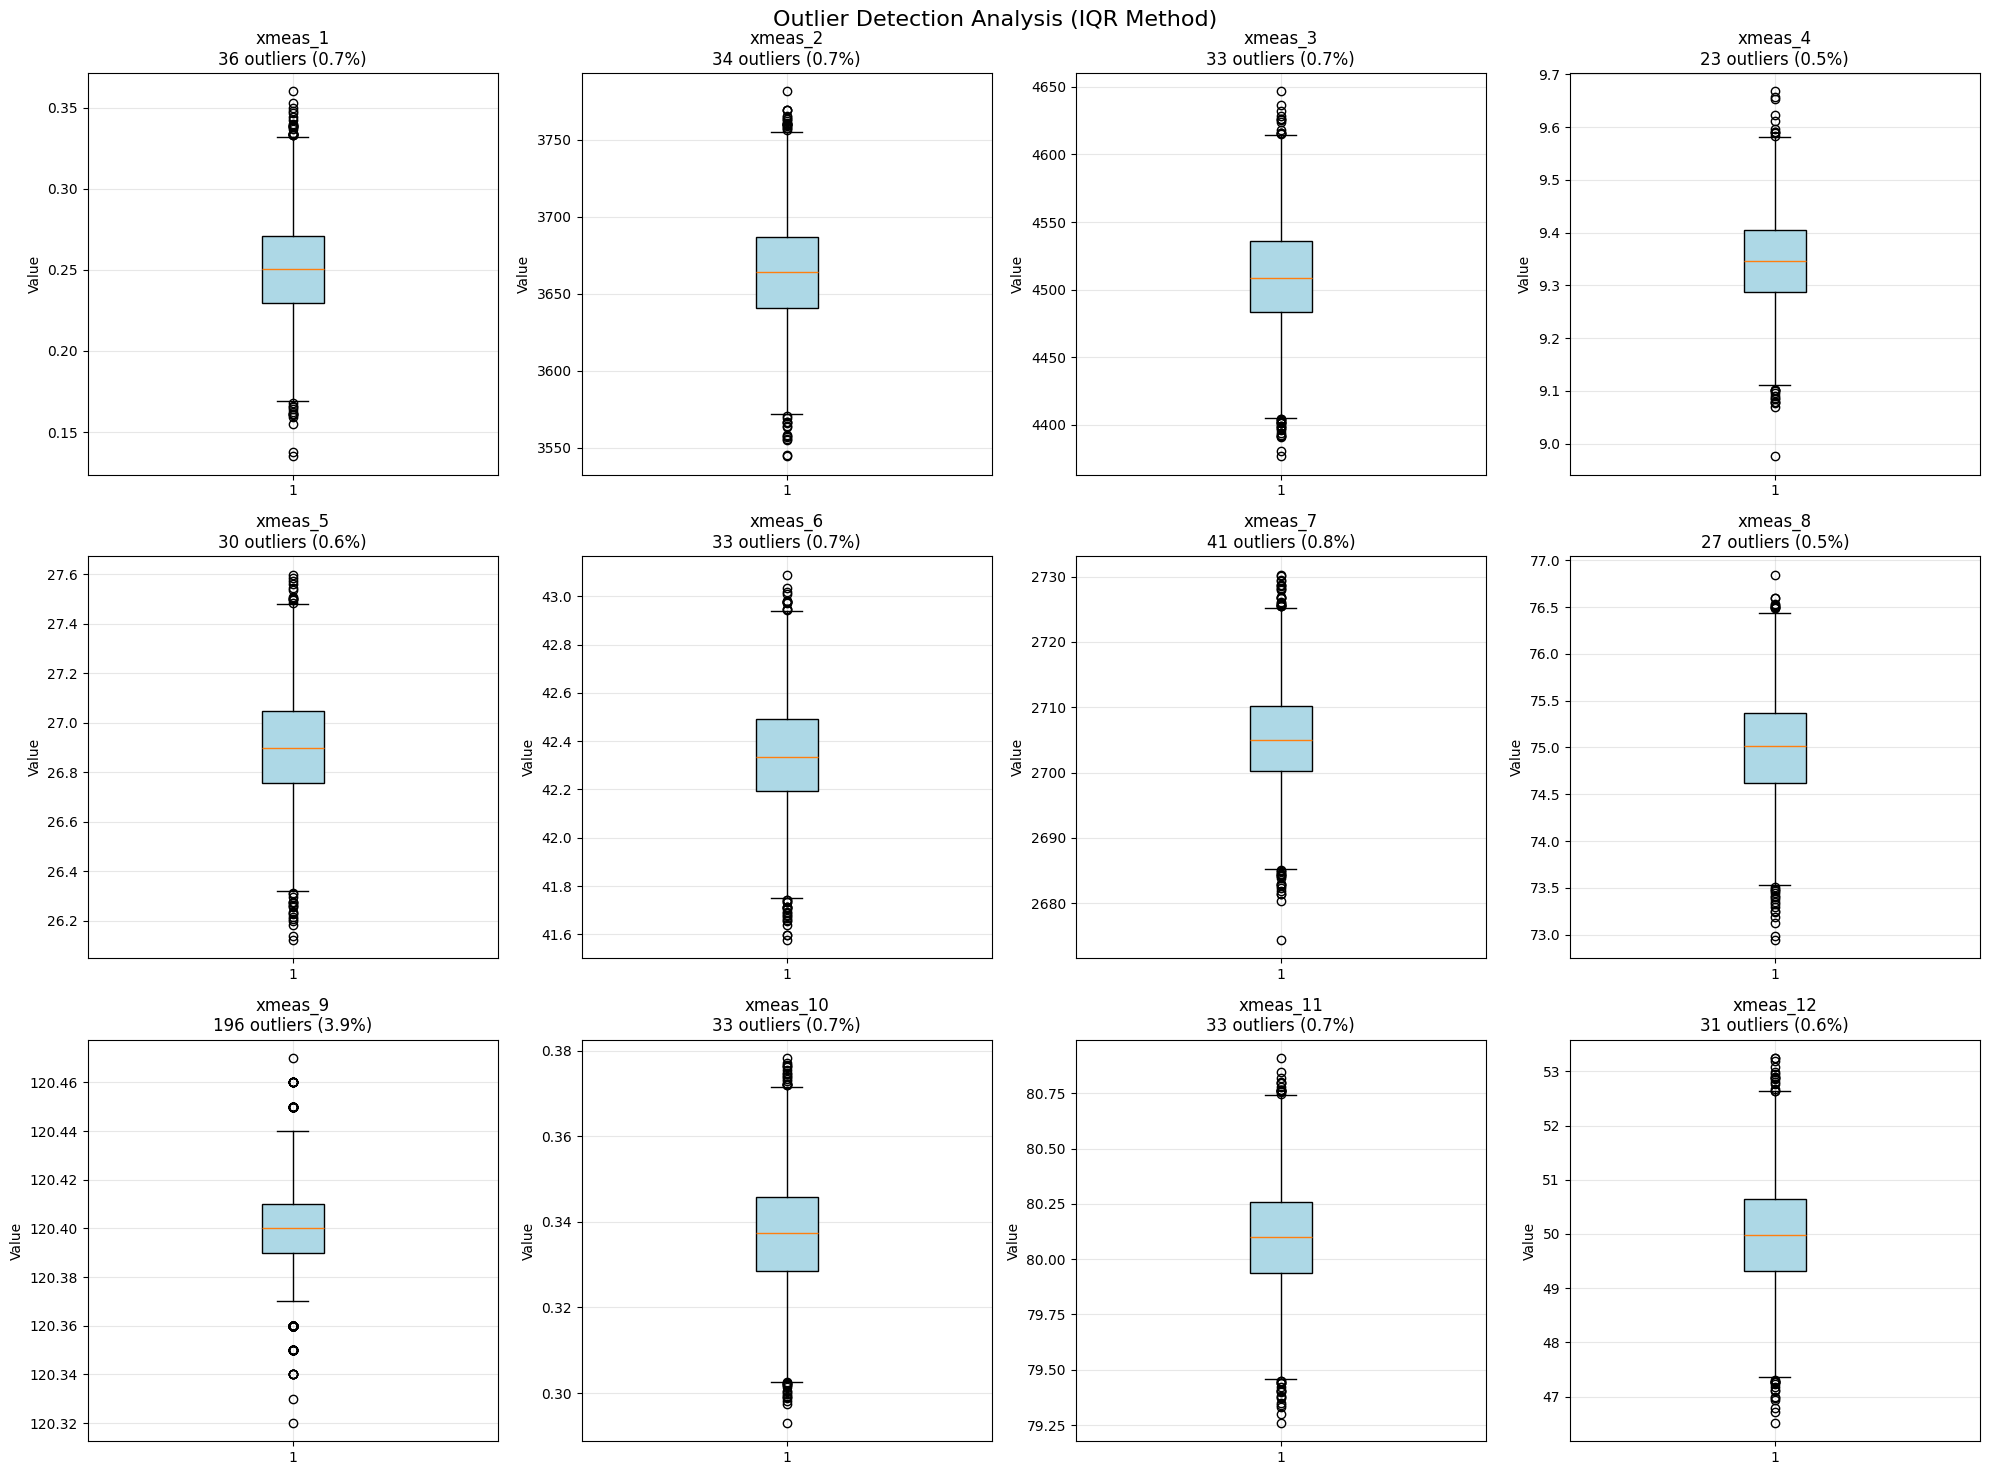

📊 Outlier Detection Summary:
   Method: IQR
   Features analyzed: 12
   Average outlier percentage: 0.92%

🔍 Top 5 features with most outliers:


,Feature,Total_Points,Outliers,Outlier_Percentage
8,xmeas_9,5000,196,3.92
6,xmeas_7,5000,41,0.82
0,xmeas_1,5000,36,0.72
1,xmeas_2,5000,34,0.68
2,xmeas_3,5000,33,0.66


💾 Data saved: output/data/outlier_analysis_iqr_v1.00.csv


In [78]:
# Outlier Detection Analysis
def detect_and_visualize_outliers(df, sample_size=5000, method='iqr'):
    """Detect and visualize outliers using IQR or Z-score method."""
    from scipy import stats
    
    # Sample data for faster computation
    df_sample = df.sample(n=min(sample_size, len(df)), random_state=42)
    feature_cols = get_feature_columns(df_sample)[:12]  # First 12 features
    
    outlier_summary = []
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    fig.suptitle(f'Outlier Detection Analysis ({method.upper()} Method)', fontsize=16)
    axes = axes.flatten()
    
    for i, feature in enumerate(feature_cols):
        if i >= 12:
            break
            
        ax = axes[i]
        data = df_sample[feature].dropna()
        
        if method == 'iqr':
            # IQR method
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = data[(data < lower_bound) | (data > upper_bound)]
        else:
            # Z-score method
            z_scores = np.abs(stats.zscore(data))
            outliers = data[z_scores > 3]
        
        # Calculate outlier percentage
        outlier_pct = (len(outliers) / len(data)) * 100
        outlier_summary.append({
            'Feature': feature,
            'Total_Points': len(data),
            'Outliers': len(outliers),
            'Outlier_Percentage': outlier_pct
        })
        
        # Create boxplot with outliers highlighted
        bp = ax.boxplot(data, patch_artist=True)
        bp['boxes'][0].set_facecolor('lightblue')
        
        # Add outlier information
        ax.set_title(f'{feature}\n{len(outliers)} outliers ({outlier_pct:.1f}%)')
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)
    
    # Remove empty subplots
    for i in range(len(feature_cols), 12):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    save_plot("outlier_detection", method)
    plt.show()
    
    # Create outlier summary
    outlier_df = pd.DataFrame(outlier_summary)
    outlier_df = outlier_df.sort_values('Outlier_Percentage', ascending=False)
    
    print("📊 Outlier Detection Summary:")
    print(f"   Method: {method.upper()}")
    print(f"   Features analyzed: {len(feature_cols)}")
    print(f"   Average outlier percentage: {outlier_df['Outlier_Percentage'].mean():.2f}%")
    print(f"\n🔍 Top 5 features with most outliers:")
    display(outlier_df.head())
    
    save_dataframe(outlier_df, "outlier_analysis", method)
    return outlier_df

print("🎯 Detecting outliers...")
outlier_results = detect_and_visualize_outliers(DF_FF_TRAINING_RAW, method='iqr')

⭐ Analyzing feature importance...
🔍 Calculating feature importance metrics...
📊 Plot saved: output/data/EDA/feature_importance_analysis_v1.00.png
📊 Plot saved: output/data/EDA/feature_importance_analysis_v1.00.png


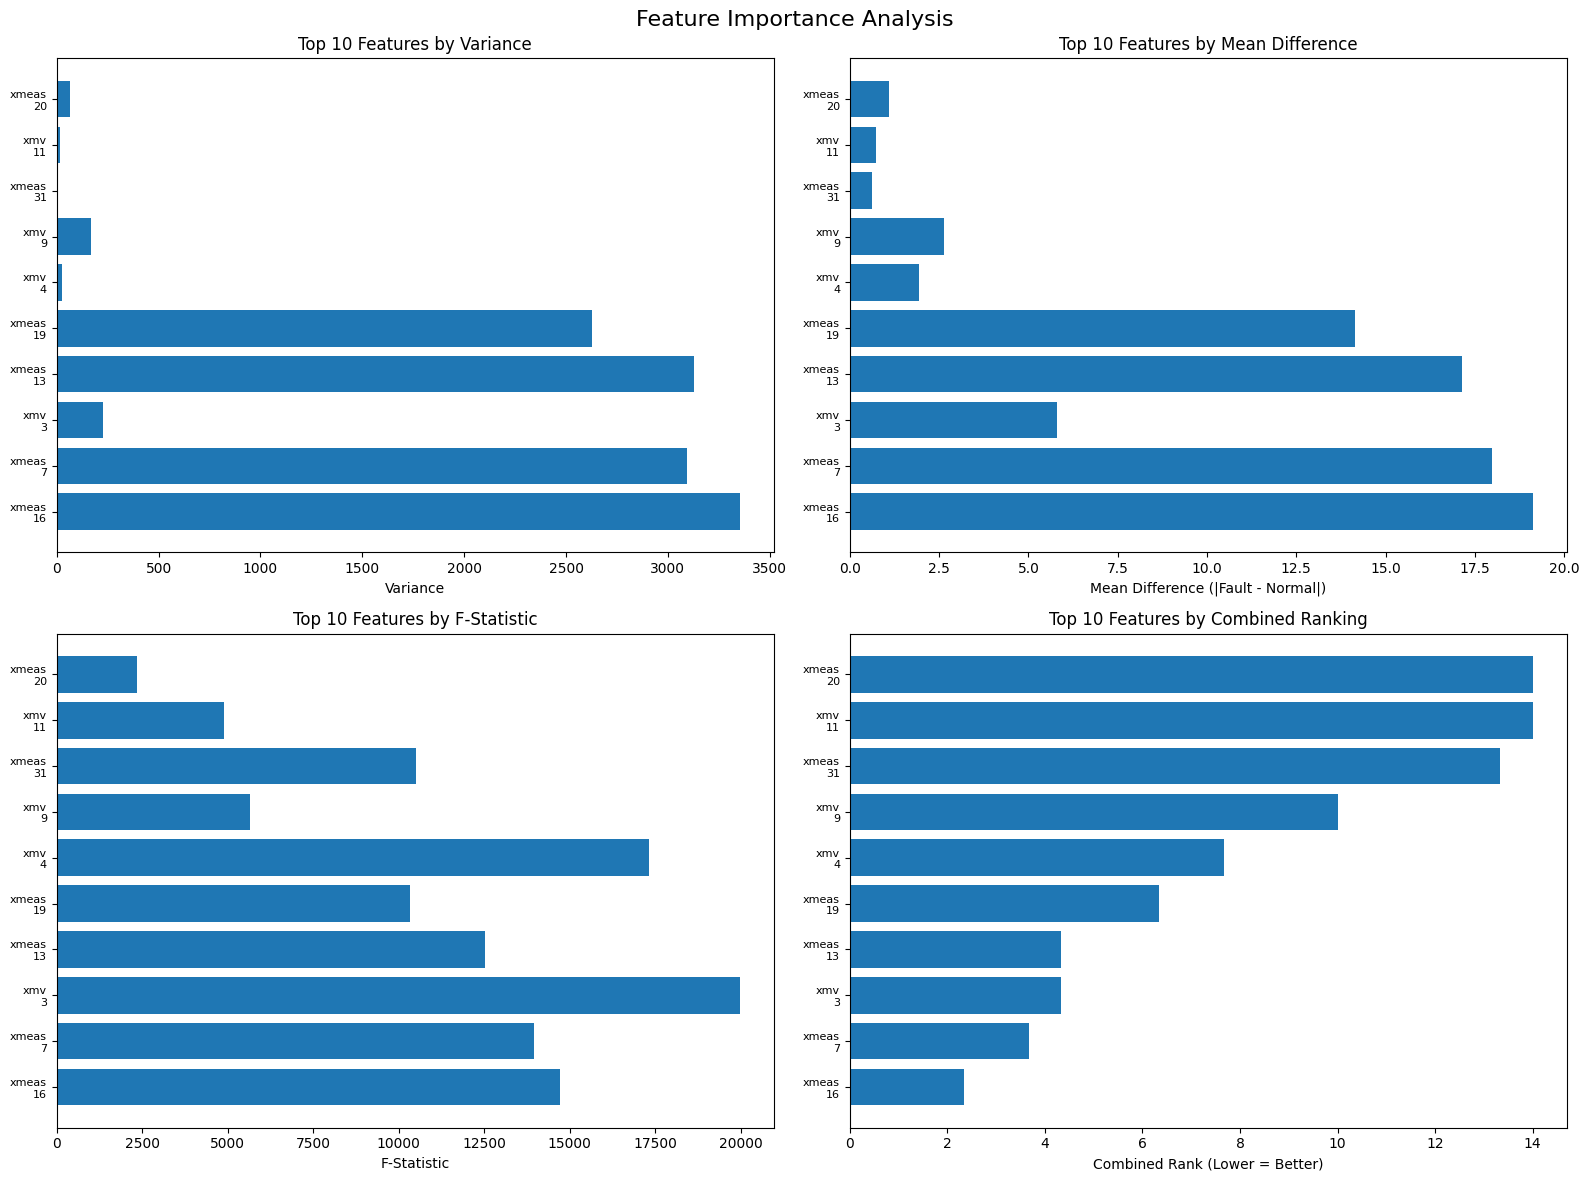

🏆 Feature Importance Summary:
   Total features analyzed: 52
   Most important feature: xmeas_16
   Highest variance: xmeas_3
   Largest mean difference: xmeas_16

📊 Top 10 Most Important Features:


,Feature,Variance,Mean_Difference,F_Statistic,Combined_Rank
15,xmeas_16,3351.560,19.120,14714.087,2.333
6,xmeas_7,3094.818,17.967,13967.929,3.667
43,xmv_3,227.964,5.792,19968.711,4.333
12,xmeas_13,3130.406,17.140,12513.113,4.333
18,xmeas_19,2627.188,14.145,10340.731,6.333
44,xmv_4,28.140,1.950,17331.428,7.667
49,xmv_9,167.480,2.647,5650.808,10.000
30,xmeas_31,5.027,0.621,10506.549,13.333
51,xmv_11,15.279,0.725,4884.751,14.000
19,xmeas_20,63.889,1.090,2335.865,14.000


💾 Data saved: output/data/feature_importance_analysis_EDA_v1.00.csv


In [79]:
# Feature Importance Analysis
def analyze_feature_importance(df_fault, df_normal, sample_size=5000):
    """Analyze feature importance using various statistical measures."""
    from scipy.stats import f_oneway, chi2_contingency
    from sklearn.feature_selection import mutual_info_classif
    from sklearn.preprocessing import StandardScaler
    
    # Sample and prepare data
    df_combined = pd.concat([
        df_normal.sample(n=min(sample_size//2, len(df_normal)), random_state=42),
        df_fault.sample(n=min(sample_size//2, len(df_fault)), random_state=42)
    ], ignore_index=True)
    
    feature_cols = get_feature_columns(df_combined)
    X = df_combined[feature_cols]
    y = df_combined[TARGET_VARIABLE_COLUMN_NAME]
    
    # Binary classification: normal (0) vs any fault (1)
    y_binary = (y > 0).astype(int)
    
    importance_results = []
    
    print("🔍 Calculating feature importance metrics...")
    
    for feature in feature_cols:
        feature_data = X[feature].fillna(X[feature].median())
        
        # 1. Variance
        variance = feature_data.var()
        
        # 2. Mean difference between normal and fault
        normal_mean = df_normal[feature].mean()
        fault_mean = df_fault[feature].mean()
        mean_diff = abs(fault_mean - normal_mean)
        
        # 3. Standard deviation ratio
        normal_std = df_normal[feature].std()
        fault_std = df_fault[feature].std()
        std_ratio = fault_std / normal_std if normal_std > 0 else 0
        
        # 4. F-statistic (ANOVA)
        try:
            normal_values = df_normal[feature].dropna()
            fault_values = df_fault[feature].dropna()
            f_stat, p_value = f_oneway(normal_values, fault_values)
        except:
            f_stat, p_value = 0, 1
        
        importance_results.append({
            'Feature': feature,
            'Variance': variance,
            'Mean_Difference': mean_diff,
            'Std_Ratio': std_ratio,
            'F_Statistic': f_stat,
            'P_Value': p_value,
            'Normal_Mean': normal_mean,
            'Fault_Mean': fault_mean
        })
    
    # Convert to DataFrame and calculate rankings
    importance_df = pd.DataFrame(importance_results)
    
    # Rank features by different metrics
    importance_df['Variance_Rank'] = importance_df['Variance'].rank(ascending=False)
    importance_df['MeanDiff_Rank'] = importance_df['Mean_Difference'].rank(ascending=False)
    importance_df['F_Stat_Rank'] = importance_df['F_Statistic'].rank(ascending=False)
    
    # Combined importance score (lower is better)
    importance_df['Combined_Rank'] = (
        importance_df['Variance_Rank'] + 
        importance_df['MeanDiff_Rank'] + 
        importance_df['F_Stat_Rank']
    ) / 3
    
    importance_df = importance_df.sort_values('Combined_Rank')
    
    # Visualize top features
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Feature Importance Analysis', fontsize=16)
    
    # Top 10 features by different metrics
    top_features = importance_df.head(10)
    
    # 1. Variance
    ax1.barh(range(len(top_features)), top_features['Variance'])
    ax1.set_yticks(range(len(top_features)))
    ax1.set_yticklabels([f.replace('_', '\n') for f in top_features['Feature']], fontsize=8)
    ax1.set_title('Top 10 Features by Variance')
    ax1.set_xlabel('Variance')
    
    # 2. Mean Difference
    ax2.barh(range(len(top_features)), top_features['Mean_Difference'])
    ax2.set_yticks(range(len(top_features)))
    ax2.set_yticklabels([f.replace('_', '\n') for f in top_features['Feature']], fontsize=8)
    ax2.set_title('Top 10 Features by Mean Difference')
    ax2.set_xlabel('Mean Difference (|Fault - Normal|)')
    
    # 3. F-Statistic
    ax3.barh(range(len(top_features)), top_features['F_Statistic'])
    ax3.set_yticks(range(len(top_features)))
    ax3.set_yticklabels([f.replace('_', '\n') for f in top_features['Feature']], fontsize=8)
    ax3.set_title('Top 10 Features by F-Statistic')
    ax3.set_xlabel('F-Statistic')
    
    # 4. Combined Ranking
    ax4.barh(range(len(top_features)), top_features['Combined_Rank'])
    ax4.set_yticks(range(len(top_features)))
    ax4.set_yticklabels([f.replace('_', '\n') for f in top_features['Feature']], fontsize=8)
    ax4.set_title('Top 10 Features by Combined Ranking')
    ax4.set_xlabel('Combined Rank (Lower = Better)')
    
    plt.tight_layout()
    save_plot("feature_importance_analysis")
    plt.show()
    
    print("🏆 Feature Importance Summary:")
    print(f"   Total features analyzed: {len(importance_df)}")
    print(f"   Most important feature: {importance_df.iloc[0]['Feature']}")
    print(f"   Highest variance: {importance_df.loc[importance_df['Variance'].idxmax(), 'Feature']}")
    print(f"   Largest mean difference: {importance_df.loc[importance_df['Mean_Difference'].idxmax(), 'Feature']}")
    
    print(f"\n📊 Top 10 Most Important Features:")
    display(top_features[['Feature', 'Variance', 'Mean_Difference', 'F_Statistic', 'Combined_Rank']].round(3))
    
    save_dataframe(importance_df, "feature_importance_analysis", "EDA")
    return importance_df

print("⭐ Analyzing feature importance...")
feature_importance = analyze_feature_importance(DF_F_TRAINING_RAW, DF_FF_TRAINING_RAW)

📈 Analyzing statistical distributions...
📊 Plot saved: output/data/EDA/statistical_distributions_analysis_v1.00.png
📊 Plot saved: output/data/EDA/statistical_distributions_analysis_v1.00.png


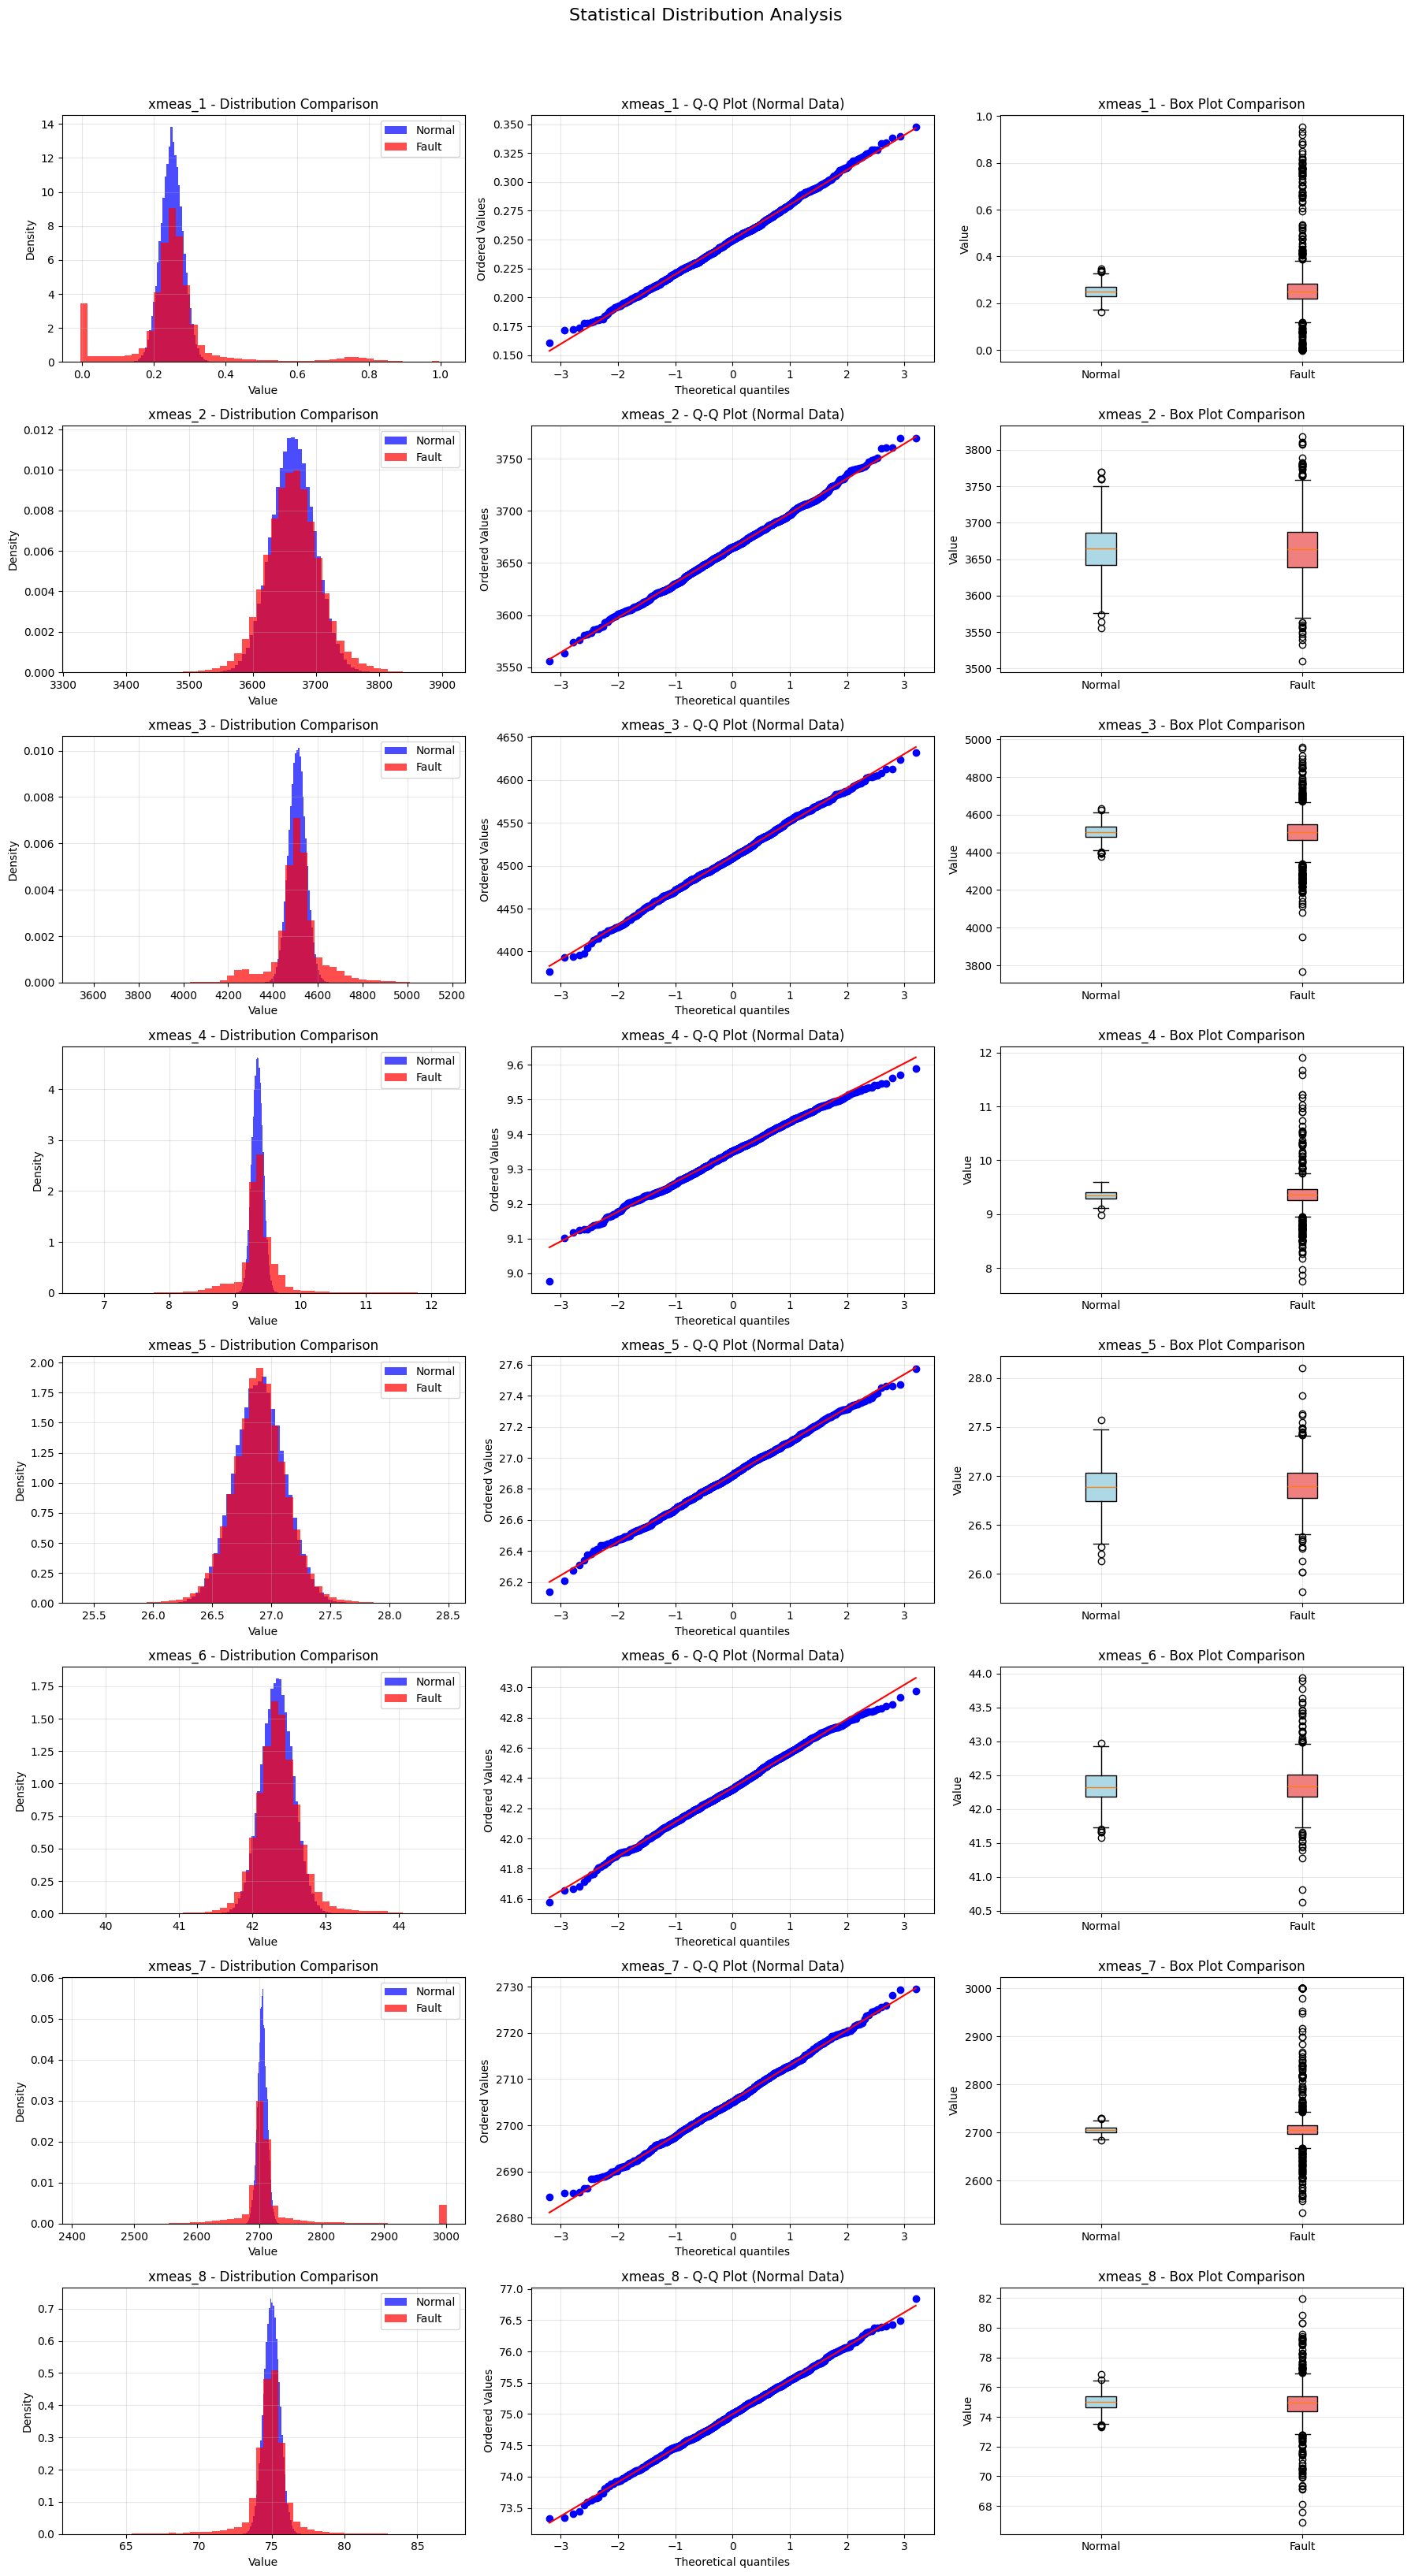

📊 Statistical Distribution Summary:
   Features analyzed: 8
   Features following normal distribution (normal data): 8/8

🔍 Normality Test Results (Normal Data):


,Feature,Shapiro_P_Value,Skewness,Kurtosis,Is_Normal
0,xmeas_1,0.7104,-0.0006,0.0157,True
2,xmeas_2,0.3163,0.0049,-0.0320,True
4,xmeas_3,0.5122,-0.0027,-0.0185,True
6,xmeas_4,0.0629,-0.0007,-0.0113,True
8,xmeas_5,0.2904,0.0059,-0.0838,True
10,xmeas_6,0.4760,-0.0088,-0.0896,True
12,xmeas_7,0.6860,0.0269,0.0975,True
14,xmeas_8,0.0688,0.0001,-0.0666,True


💾 Data saved: output/data/statistical_distributions_EDA_v1.00.csv


In [80]:
# Statistical Distribution Analysis
def analyze_statistical_distributions(df_normal, df_fault, num_features=8):
    """Analyze statistical distributions and test for normality."""
    from scipy.stats import shapiro, anderson, kstest, normaltest
    
    feature_cols = get_feature_columns(df_normal)[:num_features]
    
    # Test for normality
    normality_results = []
    
    fig, axes = plt.subplots(num_features, 3, figsize=(18, 4 * num_features))
    fig.suptitle('Statistical Distribution Analysis', fontsize=16, y=1.02)
    
    for i, feature in enumerate(feature_cols):
        # Get data
        normal_data = df_normal[feature].dropna()
        fault_data = df_fault[feature].dropna()
        
        # Normality tests for normal data
        shapiro_stat, shapiro_p = shapiro(normal_data.sample(min(5000, len(normal_data)), random_state=42))
        anderson_result = anderson(normal_data.sample(min(5000, len(normal_data)), random_state=42))
        
        # Store results
        normality_results.append({
            'Feature': feature,
            'Data_Type': 'Normal',
            'Shapiro_Stat': shapiro_stat,
            'Shapiro_P_Value': shapiro_p,
            'Anderson_Stat': anderson_result.statistic,
            'Skewness': skew(normal_data),
            'Kurtosis': kurtosis(normal_data),
            'Mean': normal_data.mean(),
            'Std': normal_data.std()
        })
        
        # Normality tests for fault data  
        fault_sample = fault_data.sample(min(5000, len(fault_data)), random_state=42)
        shapiro_stat_f, shapiro_p_f = shapiro(fault_sample)
        anderson_result_f = anderson(fault_sample)
        
        normality_results.append({
            'Feature': feature,
            'Data_Type': 'Fault',
            'Shapiro_Stat': shapiro_stat_f,
            'Shapiro_P_Value': shapiro_p_f,
            'Anderson_Stat': anderson_result_f.statistic,
            'Skewness': skew(fault_data),
            'Kurtosis': kurtosis(fault_data),
            'Mean': fault_data.mean(),
            'Std': fault_data.std()
        })
        
        # Plot 1: Histogram comparison
        ax1 = axes[i, 0]
        ax1.hist(normal_data, bins=50, alpha=0.7, label='Normal', color='blue', density=True)
        ax1.hist(fault_data, bins=50, alpha=0.7, label='Fault', color='red', density=True)
        ax1.set_title(f'{feature} - Distribution Comparison')
        ax1.set_xlabel('Value')
        ax1.set_ylabel('Density')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Q-Q plots
        ax2 = axes[i, 1]
        from scipy.stats import probplot
        probplot(normal_data.sample(min(1000, len(normal_data)), random_state=42), 
                dist="norm", plot=ax2)
        ax2.set_title(f'{feature} - Q-Q Plot (Normal Data)')
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Box plots comparison
        ax3 = axes[i, 2]
        box_data = [normal_data.sample(min(1000, len(normal_data)), random_state=42),
                   fault_data.sample(min(1000, len(fault_data)), random_state=42)]
        bp = ax3.boxplot(box_data, labels=['Normal', 'Fault'], patch_artist=True)
        bp['boxes'][0].set_facecolor('lightblue')
        bp['boxes'][1].set_facecolor('lightcoral')
        ax3.set_title(f'{feature} - Box Plot Comparison')
        ax3.set_ylabel('Value')
        ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_plot("statistical_distributions_analysis")
    plt.show()
    
    # Create normality summary
    normality_df = pd.DataFrame(normality_results)
    
    # Summary statistics
    print("📊 Statistical Distribution Summary:")
    print(f"   Features analyzed: {num_features}")
    
    # Check normality (p > 0.05 suggests normal distribution)
    normal_features = normality_df[
        (normality_df['Data_Type'] == 'Normal') & 
        (normality_df['Shapiro_P_Value'] > 0.05)
    ]
    print(f"   Features following normal distribution (normal data): {len(normal_features)}/{num_features}")
    
    print(f"\n🔍 Normality Test Results (Normal Data):")
    normal_summary = normality_df[normality_df['Data_Type'] == 'Normal'].copy()
    normal_summary['Is_Normal'] = normal_summary['Shapiro_P_Value'] > 0.05
    display(normal_summary[['Feature', 'Shapiro_P_Value', 'Skewness', 'Kurtosis', 'Is_Normal']].round(4))
    
    save_dataframe(normality_df, "statistical_distributions", "EDA")
    return normality_df

print("📈 Analyzing statistical distributions...")
distribution_results = analyze_statistical_distributions(DF_FF_TRAINING_RAW, DF_F_TRAINING_RAW)

🔬 Performing multivariate analysis...
📊 Plot saved: output/data/EDA/multivariate_analysis_v1.00.png
📊 Plot saved: output/data/EDA/multivariate_analysis_v1.00.png


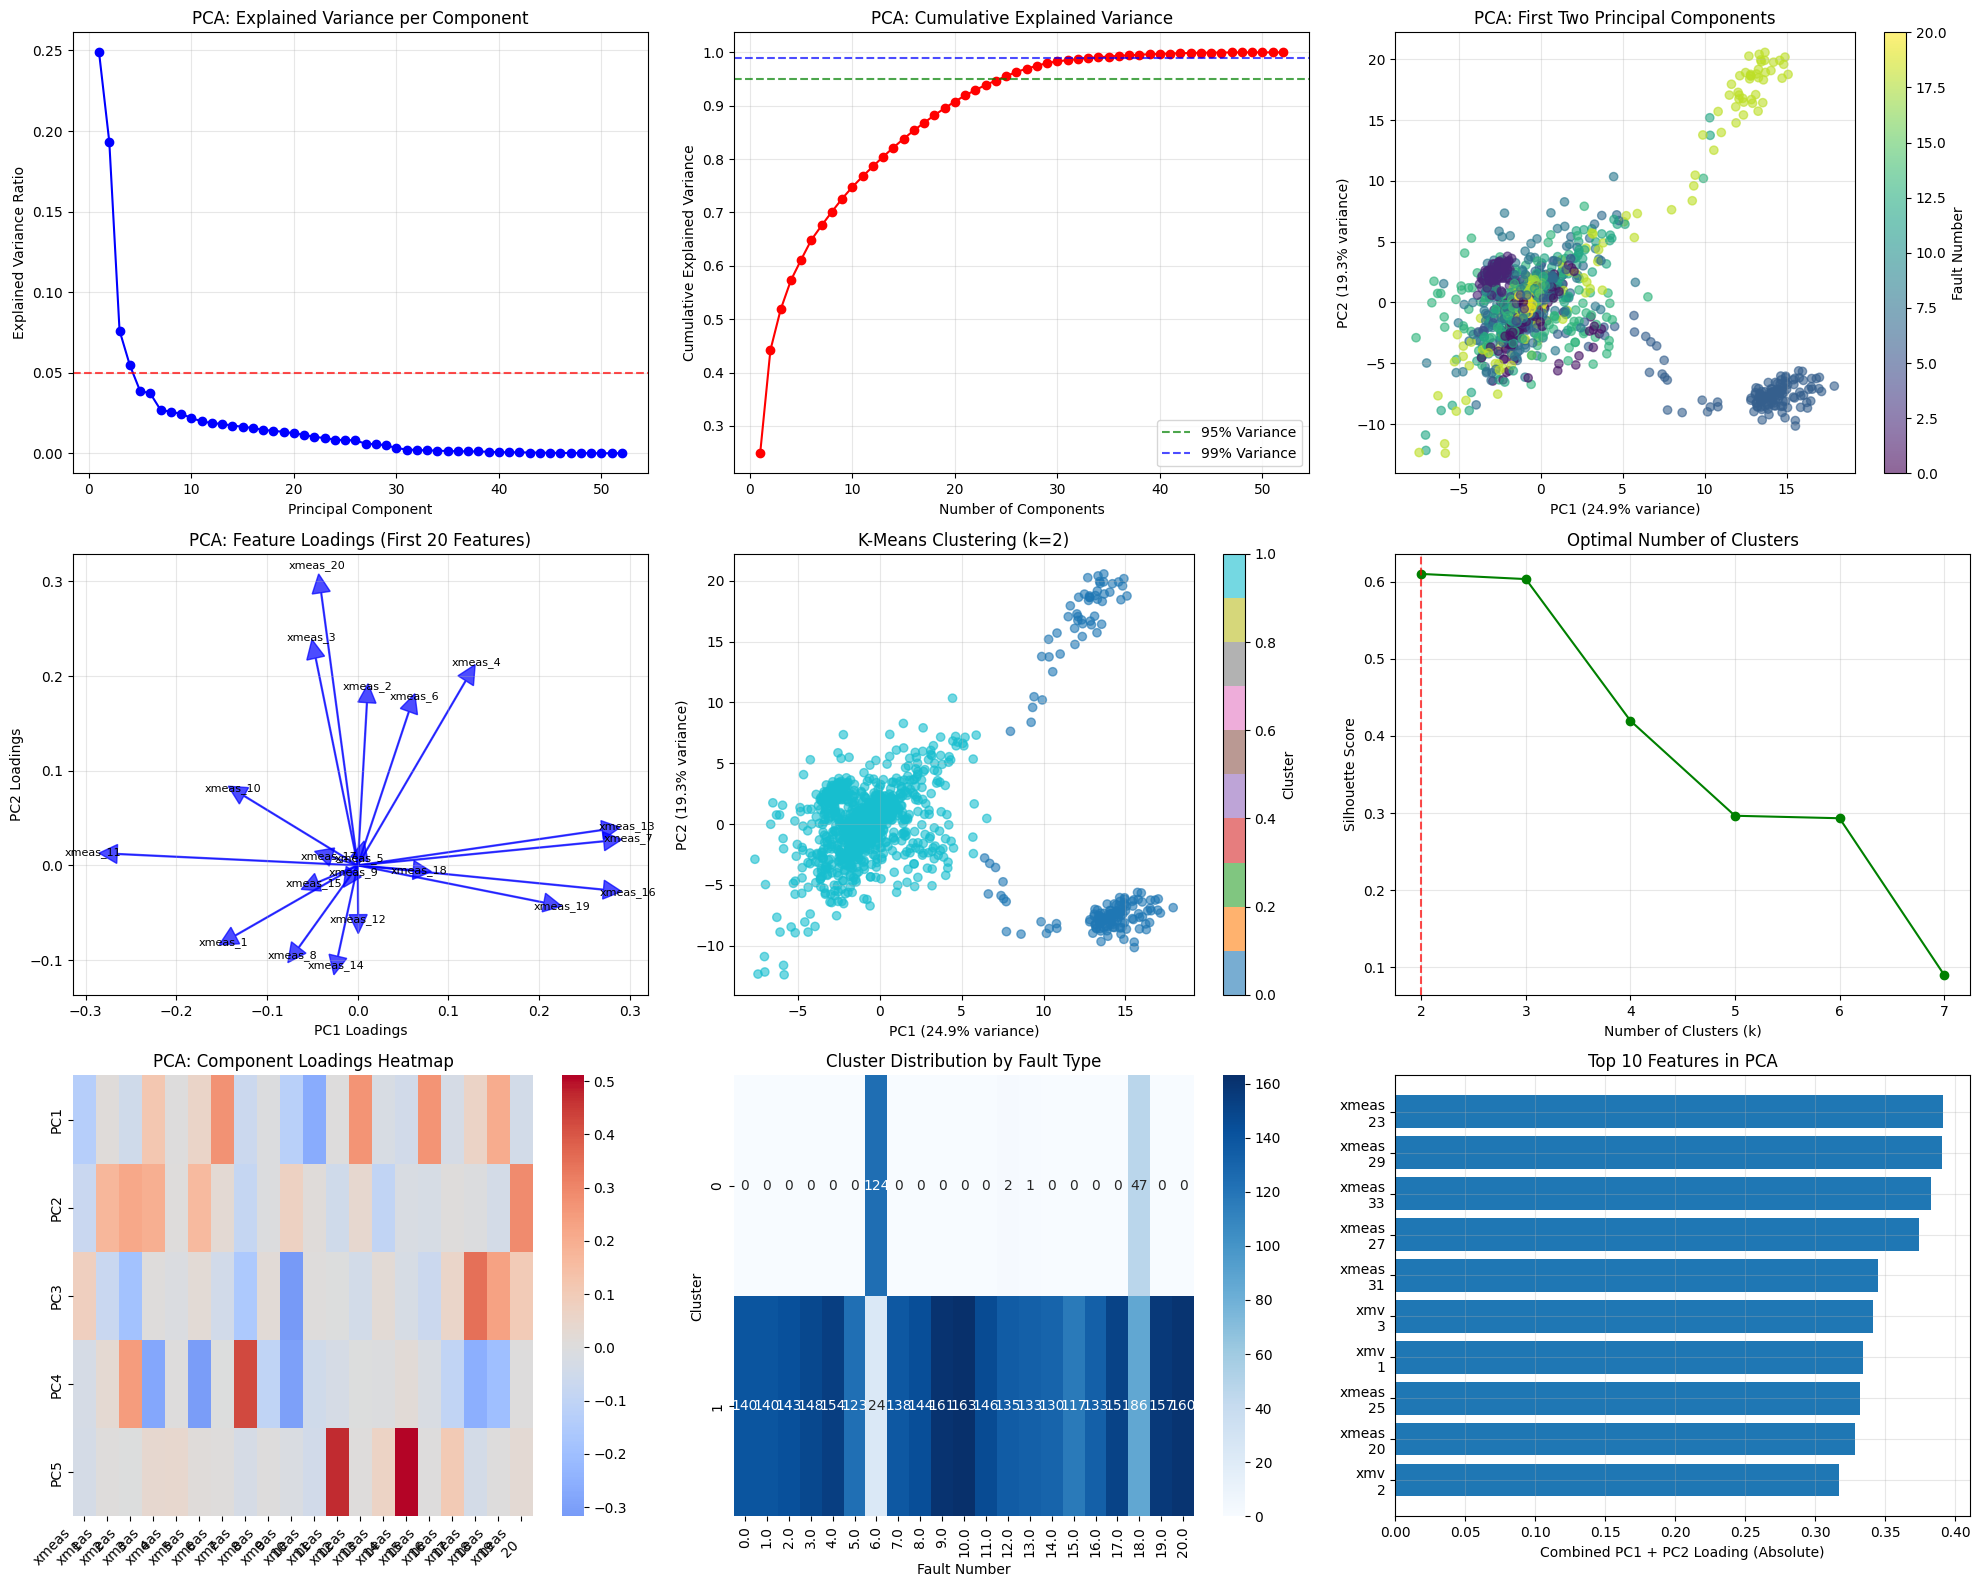

🔍 Multivariate Analysis Summary:
   Total features: 52
   Components for 95% variance: 25
   Components for 99% variance: 34
   Optimal number of clusters: 2
   Best silhouette score: 0.610
💾 Data saved: output/data/multivariate_analysis_summary_EDA_v1.00.csv


In [84]:
# Multivariate Analysis and Dimensionality Reduction
def perform_multivariate_analysis(df_combined, sample_size=3000):
    """Perform PCA, clustering, and multivariate analysis."""
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    
    # Sample and prepare data
    df_sample = df_combined.sample(n=min(sample_size, len(df_combined)), random_state=42)
    feature_cols = get_feature_columns(df_sample)
    
    X = df_sample[feature_cols].fillna(df_sample[feature_cols].median())
    y = df_sample[TARGET_VARIABLE_COLUMN_NAME]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # PCA Analysis
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    # Calculate cumulative explained variance
    cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1
    n_components_99 = np.argmax(cumsum_variance >= 0.99) + 1
    
    # Clustering Analysis
    # Find optimal number of clusters using silhouette score
    k_range = range(2, 8)
    silhouette_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_scaled)
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    optimal_k = k_range[np.argmax(silhouette_scores)]
    
    # Final clustering with optimal k
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans_final.fit_predict(X_scaled)
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 16))
    
    # 1. PCA Explained Variance
    ax1 = plt.subplot(3, 3, 1)
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
             pca.explained_variance_ratio_, 'bo-')
    plt.axhline(y=0.05, color='r', linestyle='--', alpha=0.7)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA: Explained Variance per Component')
    plt.grid(True, alpha=0.3)
    
    # 2. Cumulative Explained Variance
    ax2 = plt.subplot(3, 3, 2)
    plt.plot(range(1, len(cumsum_variance) + 1), cumsum_variance, 'ro-')
    plt.axhline(y=0.95, color='g', linestyle='--', alpha=0.7, label='95% Variance')
    plt.axhline(y=0.99, color='b', linestyle='--', alpha=0.7, label='99% Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA: Cumulative Explained Variance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. PCA Scatter Plot (first 2 components)
    ax3 = plt.subplot(3, 3, 3)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.6)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.title('PCA: First Two Principal Components')
    plt.colorbar(scatter, label='Fault Number')
    plt.grid(True, alpha=0.3)
    
    # 4. Feature Loadings (PC1 vs PC2)
    ax4 = plt.subplot(3, 3, 4)
    loadings = pca.components_[:2].T
    for i, feature in enumerate(feature_cols[:20]):  # Show first 20 features
        plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], 
                 head_width=0.02, head_length=0.02, fc='blue', ec='blue', alpha=0.7)
        plt.text(loadings[i, 0]*1.1, loadings[i, 1]*1.1, feature, 
                fontsize=8, ha='center', va='center')
    plt.xlabel('PC1 Loadings')
    plt.ylabel('PC2 Loadings')
    plt.title('PCA: Feature Loadings (First 20 Features)')
    plt.grid(True, alpha=0.3)
    
    # 5. Clustering Results
    ax5 = plt.subplot(3, 3, 5)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', alpha=0.6)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.title(f'K-Means Clustering (k={optimal_k})')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True, alpha=0.3)
    
    # 6. Silhouette Scores
    ax6 = plt.subplot(3, 3, 6)
    plt.plot(k_range, silhouette_scores, 'go-')
    plt.axvline(x=optimal_k, color='r', linestyle='--', alpha=0.7)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Optimal Number of Clusters')
    plt.grid(True, alpha=0.3)
    
    # 7. Top PCA Components Heatmap
    ax7 = plt.subplot(3, 3, 7)
    top_components = pca.components_[:5, :20]  # Top 5 components, first 20 features
    sns.heatmap(top_components, 
                xticklabels=[f.replace('_', '\n') for f in feature_cols[:20]], 
                yticklabels=[f'PC{i+1}' for i in range(5)],
                cmap='coolwarm', center=0, annot=False)
    plt.title('PCA: Component Loadings Heatmap')
    plt.xticks(rotation=45, ha='right')
    
    # 8. Cluster Distribution by Fault Type
    ax8 = plt.subplot(3, 3, 8)
    cluster_fault_crosstab = pd.crosstab(cluster_labels, y)
    sns.heatmap(cluster_fault_crosstab, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Fault Number')
    plt.ylabel('Cluster')
    plt.title('Cluster Distribution by Fault Type')
    
    # 9. Explained Variance by Top Features
    ax9 = plt.subplot(3, 3, 9)
    feature_importance_pca = np.abs(pca.components_[0]) + np.abs(pca.components_[1])
    top_features_idx = np.argsort(feature_importance_pca)[-10:]
    plt.barh(range(10), feature_importance_pca[top_features_idx])
    plt.yticks(range(10), [feature_cols[i].replace('_', '\n') for i in top_features_idx])
    plt.xlabel('Combined PC1 + PC2 Loading (Absolute)')
    plt.title('Top 10 Features in PCA')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_plot("multivariate_analysis")
    plt.show()
    
    # Summary statistics
    print("🔍 Multivariate Analysis Summary:")
    print(f"   Total features: {len(feature_cols)}")
    print(f"   Components for 95% variance: {n_components_95}")
    print(f"   Components for 99% variance: {n_components_99}")
    print(f"   Optimal number of clusters: {optimal_k}")
    print(f"   Best silhouette score: {max(silhouette_scores):.3f}")
    
    # Create summary DataFrame
    multivariate_summary = {
        'Total_Features': len(feature_cols),
        'PC_95_Variance': n_components_95,
        'PC_99_Variance': n_components_99,
        'Optimal_Clusters': optimal_k,
        'Best_Silhouette_Score': max(silhouette_scores),
        'PC1_Variance_Explained': pca.explained_variance_ratio_[0],
        'PC2_Variance_Explained': pca.explained_variance_ratio_[1],
        'Total_PC1_PC2_Variance': pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]
    }
    
    summary_df = pd.DataFrame([multivariate_summary])
    save_dataframe(summary_df, "multivariate_analysis_summary", "EDA")
    
    return {
        'pca': pca,
        'scaler': scaler,
        'cluster_labels': cluster_labels,
        'optimal_k': optimal_k,
        'silhouette_scores': silhouette_scores,
        'summary': multivariate_summary
    }
    
# Combine normal and fault data for multivariate analysis
df_combined_mv = pd.concat([DF_FF_TRAINING_RAW, DF_F_TRAINING_RAW], ignore_index=True)
print("🔬 Performing multivariate analysis...")
multivariate_results = perform_multivariate_analysis(df_combined_mv)

## 5. Summary & Export

In [83]:
# Generate comprehensive summary and export results
def generate_comprehensive_summary():
    """Generate and export comprehensive EDA summary."""
    
    feature_cols = get_feature_columns(DF_F_TRAINING_RAW)
    
    print("=" * 80)
    print("COMPREHENSIVE EDA SUMMARY")
    print("=" * 80)
    
    # Dataset summary
    print(f"\n📊 DATASET OVERVIEW:")
    print(f"   Fault-free training samples: {len(DF_FF_TRAINING_RAW):,}")
    print(f"   Faulty training samples: {len(DF_F_TRAINING_RAW):,}")
    print(f"   Total features: {len(feature_cols)}")
    print(f"   Unique faults: {len(DF_F_TRAINING_RAW[TARGET_VARIABLE_COLUMN_NAME].unique())}")
    print(f"   Simulation runs: {len(DF_F_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME].unique())}")
    
    # Generate summary statistics
    normal_summary = DF_FF_TRAINING_RAW[feature_cols].describe()
    save_dataframe(normal_summary, "summary_statistics_normal", "EDA")
    
    faulty_summary = DF_F_TRAINING_RAW[feature_cols].describe()
    save_dataframe(faulty_summary, "summary_statistics_faulty", "EDA")
    
    # Feature analysis
    print(f"\n📋 FEATURE ANALYSIS:")
    normal_means = normal_summary.loc['mean']
    faulty_means = faulty_summary.loc['mean']
    
    # Features with largest differences
    mean_differences = abs(faulty_means - normal_means).sort_values(ascending=False)
    print(f"   Features with largest mean differences (top 5):")
    for i, (feature, diff) in enumerate(mean_differences.head(5).items(), 1):
        print(f"      {i}. {feature}: {diff:.3f}")
    
    # Export files summary
    print(f"\n💾 EXPORTED FILES:")
    print(f"   📊 comprehensive_statistics_EDA_v{VERSION}.csv")
    print(f"   📊 summary_statistics_normal_EDA_v{VERSION}.csv") 
    print(f"   📊 summary_statistics_faulty_EDA_v{VERSION}.csv")
    print(f"   📊 fault_distribution_EDA_v{VERSION}.csv")
    
    print(f"\n🎨 GENERATED PLOTS:")
    print(f"   📈 Distribution comparisons (boxplots)")
    print(f"   📊 Correlation analysis matrices")
    print(f"   🎯 Fault distribution charts")
    print(f"   🔍 t-SNE dimensionality reduction")
    
    # Create master summary
    master_summary = {
        'Dataset': 'Tennessee Eastman Process',
        'Analysis_Date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'Normal_Samples': len(DF_FF_TRAINING_RAW),
        'Faulty_Samples': len(DF_F_TRAINING_RAW),
        'Total_Features': len(feature_cols),
        'Unique_Faults': len(DF_F_TRAINING_RAW[TARGET_VARIABLE_COLUMN_NAME].unique()),
        'Simulation_Runs': len(DF_F_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME].unique()),
        'Version': VERSION
    }
    
    master_df = pd.DataFrame([master_summary])
    save_dataframe(master_df, "eda_master_summary", "EDA")
    
    print(f"\n✅ EDA ANALYSIS COMPLETE!")
    print(f"📁 All outputs saved to: {OUTPUT_PATH}/data/")
    
    return master_summary

# Generate final summary
eda_summary = generate_comprehensive_summary()

print(f"\n🎉 Exploratory Data Analysis completed successfully!")
print(f"📁 Results saved to: {OUTPUT_PATH}/data/")
print(f"🔍 Check the generated CSV files and plots for detailed insights")

COMPREHENSIVE EDA SUMMARY

📊 DATASET OVERVIEW:
   Fault-free training samples: 250,000
   Faulty training samples: 5,000,000
   Total features: 52
   Unique faults: 20
   Simulation runs: 500
💾 Data saved: output/data/summary_statistics_normal_EDA_v1.00.csv
💾 Data saved: output/data/summary_statistics_normal_EDA_v1.00.csv
💾 Data saved: output/data/summary_statistics_faulty_EDA_v1.00.csv

📋 FEATURE ANALYSIS:
   Features with largest mean differences (top 5):
      1. xmeas_16: 19.120
      2. xmeas_7: 17.967
      3. xmeas_13: 17.140
      4. xmeas_19: 14.145
      5. xmv_3: 5.792

💾 EXPORTED FILES:
   📊 comprehensive_statistics_EDA_v1.00.csv
   📊 summary_statistics_normal_EDA_v1.00.csv
   📊 summary_statistics_faulty_EDA_v1.00.csv
   📊 fault_distribution_EDA_v1.00.csv

🎨 GENERATED PLOTS:
   📈 Distribution comparisons (boxplots)
   📊 Correlation analysis matrices
   🎯 Fault distribution charts
   🔍 t-SNE dimensionality reduction
💾 Data saved: output/data/eda_master_summary_EDA_v1.00.csv


## Conclusion

This comprehensive EDA has provided insights into:

1. **Dataset Structure**: Tennessee Eastman Process with 20+ fault types across multiple simulation runs
2. **Feature Characteristics**: Identified high-variance and highly correlated features
3. **Fault Patterns**: Analyzed differences between normal and faulty operations
4. **Distribution Analysis**: Examined fault class distributions and feature comparisons
5. **Dimensionality**: Visualized high-dimensional data structure using t-SNE

**Key Findings:**
- Clear separation between normal and faulty operations in many features
- Uneven distribution of fault classes across the dataset
- High correlation exists between certain process variables
- Feature importance varies significantly across the dataset

**Next Steps:**
- Use identified important features for fault classification
- Consider fault similarities for merging strategies  
- Apply correlation analysis insights for feature selection
- Leverage distribution analysis for data preprocessing

In [ ]:
# Calculate comprehensive statistics per fault run
# Using reduced data for speed (first 3 simulation runs)
print("=== CALCULATING COMPREHENSIVE STATISTICS ===")
statics_f_df = DF_F_TRAINING_RAW[(DF_F_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME] >= 1)
                             & (DF_F_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME] < 4)]
statics_ff_df = DF_FF_TRAINING_RAW[(DF_FF_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME] >= 1)
                               & (DF_FF_TRAINING_RAW[SIMULATION_RUN_COLUMN_NAME] < 4)]

print(f"Reduced faulty data shape: {statics_f_df.shape}")
print(f"Reduced fault-free data shape: {statics_ff_df.shape}")

# Calculate statistics using the correct function name
stats_df = calculate_comprehensive_statistics(df_faulty=statics_f_df,
                                              df_normal=statics_ff_df)

print(f"\nStatistics dataframe shape: {stats_df.shape}")
print("Sample of calculated statistics:")
display(stats_df.head(10))

# Save the statistics
save_dataframe(stats_df, "comprehensive_fault_statistics", "EDA")

# Show statistics for a specific fault
print("\n=== STATISTICS FOR FAULT 3, RUN 1 ===")
display(stats_df.query("faultNumber == 3 and simulationRun == 1").head())

=== CALCULATING COMPREHENSIVE STATISTICS ===
Reduced faulty data shape: (30000, 55)
Reduced fault-free data shape: (1500, 55)
💾 Data saved: output/data/comprehensive_statistics_EDA_v1.00.csv

Statistics dataframe shape: (3276, 10)
Sample of calculated statistics:
💾 Data saved: output/data/comprehensive_statistics_EDA_v1.00.csv

Statistics dataframe shape: (3276, 10)
Sample of calculated statistics:


,faultNumber,simulationRun,feature,mean,std,min,max,skewness,kurtosis,autocorr_1
0,0.0,1.0,xmeas_1,0.250589,0.028053,0.16335,0.33642,0.092199,0.054638,0.603644
1,0.0,1.0,xmeas_2,3662.773200,32.682159,3564.60000,3775.00000,0.097979,0.332577,0.364918
2,0.0,1.0,xmeas_3,4509.577200,38.719848,4400.50000,4613.40000,0.064323,-0.009796,0.432310
3,0.0,1.0,xmeas_4,9.344804,0.078888,9.12660,9.57570,0.129982,-0.181824,0.263978
4,0.0,1.0,xmeas_5,26.907058,0.214969,26.20100,27.50100,-0.125848,0.086170,-0.012240
5,0.0,1.0,xmeas_6,42.340676,0.220381,41.79600,43.04000,0.234513,-0.097109,-0.003553
6,0.0,1.0,xmeas_7,2704.357000,5.970479,2692.30000,2717.70000,0.223098,-0.828060,0.944140
7,0.0,1.0,xmeas_8,75.017246,0.527373,73.67700,76.53800,0.019236,0.047426,0.201402
8,0.0,1.0,xmeas_9,120.400040,0.019513,120.32000,120.47000,-0.112534,0.395387,-0.171673
9,0.0,1.0,xmeas_10,0.337032,0.011672,0.30296,0.37536,-0.026209,0.504947,0.537800


💾 Data saved: output/data/comprehensive_fault_statistics_EDA_v1.00.csv

=== STATISTICS FOR FAULT 3, RUN 1 ===


,faultNumber,simulationRun,feature,mean,std,min,max,skewness,kurtosis,autocorr_1
468,3.0,1.0,xmeas_1,0.250590,0.028047,0.1633,0.33602,0.087095,0.045981,0.603482
469,3.0,1.0,xmeas_2,3662.771000,32.686947,3564.6000,3775.10000,0.098014,0.332652,0.365085
470,3.0,1.0,xmeas_3,4509.553200,38.705415,4399.9000,4613.50000,0.061717,-0.003970,0.431878
471,3.0,1.0,xmeas_4,9.344781,0.078973,9.1266,9.57600,0.129034,-0.182764,0.265598
472,3.0,1.0,xmeas_5,26.907070,0.214965,26.2010,27.50100,-0.125808,0.085780,-0.012288
